In [ ]:
"""
    Ranking:
        1.1 Hierarchical Clustering (ranking_prediction.ipynb)
        1.2 Map labels to future matches as home and away of past season
            1.2.1 If team is new, label it as normal (which is a not promoted team)
        1.3 Compute difference in ranking (NO because of no sequential)
        1.4 Future work: study the week development of the league to see if there is a point where
            it can be started to predict the actual behavior of the team as the promotion label
    Prediction:
        2.0 Drop features --> computation differences (visualization.ipynb)
        2.1 Features TEST
            2.1.0 First match as median of past season (already started) TODO
            2.1.2 Median of current season (home and away games are definetely a factor)
            2.1.2.1 Median at home/away <-- Just this
            2.1.2.2 Past average of last n games (test with 3, 5, etc)
            2.1.2.3 Average of last n games at home/away
"""

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import playstyle
import pickle
import ranking
sns.set_style('darkgrid')

In [2]:
"""
    Everything to create the clusters
"""
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

# Returns Z, coph_matrix and best cophence score from HC
def HierarchicalClustering(data, label):
    methods = ["single","complete","average","centroid","ward"]

    # Pass the dataset into pdist to get your proximity matrix for calculating CPCC
    proximity_matrix = pdist(data)

    best_coph = -1
    best_method = None

    for method in methods:
        Z = linkage(data, method)
        coph, coph_matrix = cophenet(Z, proximity_matrix)
        if coph > best_coph:
            best_coph = coph
            best_method = method
            best_matrix = coph_matrix
        Z = linkage(data, best_method)
        coph_matrix = cophenet(Z)
    return Z, coph_matrix, best_coph

#Returns a dictionary with the clusters in the form
#"id": "season" : point -> Attr object
def dct_clusters(dct_clusters, Z, coph_matrix, dendo_label, criterion='distance', real=None):
    if real != None:
        clusters = real[2]
    else:
        clusters = fcluster(Z, t=coph_matrix[0], criterion=criterion)
    for i in range(0, len(dendo_label)):
        point = ranking.Attr(dendo_label[i], clusters[i])
        if point.value2 not in dct_clusters:
            dct_clusters[point.value2] = {}
            dct_clusters[point.value2][point.value3] = point
        else:
            dct_clusters[point.value2][point.value3] = point
    return dct_clusters, clusters

# Return the cluster of an specific type
def get_cluster_of_type(all_dct, country, league, seasons, target_col, clean_type, real=None):
    # Data initialization
    data, column_names = ranking.concat_data(country, league, seasons, target_col, clean_type)
    all_data, all_season, all_names, all_target = ranking.get_all_data(data, len(target_col))
    # Use Agglomerative
    all_data = preprocessing.StandardScaler().fit_transform(all_data)
    dendo_label = ranking.label_team_season(all_names, all_season)
    Z, coph_matrix, coph = HierarchicalClustering(all_data, dendo_label)
    if real == None:
        all_dct, all_lst = dct_clusters(all_dct, Z, coph_matrix, dendo_label)
    else:
        all_dct, all_lst = dct_clusters(all_dct, Z, coph_matrix, dendo_label, real=all_target)
    return all_dct

#Returns three clusters as: overall, home and away performance
def get_clusters(country, league, season, year_window=1):
    # Historicity: multi season directory
    start_season = season
    seasons = list(range(start_season, start_season - year_window, -1))
    seasons = sorted(seasons, reverse=True)
    # Targets
    target_col = ["rank", "points", "description"]
    # Gets the dictionary
    overall_dct = dict()
    home_dct = dict()
    away_dct = dict()
    real_dct = dict()
    for season in seasons:
        season = [season]
        real_dct = get_cluster_of_type(overall_dct, country, league, season, target_col, clean_type=None, real=True)
        overall_dct = get_cluster_of_type(overall_dct, country, league, season, target_col, clean_type=None)
        home_dct = get_cluster_of_type(home_dct, country, league, season, target_col, clean_type='home')
        away_dct = get_cluster_of_type(away_dct, country, league, season, target_col, clean_type='away')
    return (overall_dct, home_dct, away_dct, real_dct)

In [3]:
"""
    Creates the statistics dataset
"""
def get_statistics(country, league, curr_week, season, year_window=1):
    # Historicity: multi season directory
    start_season = season
    seasons = list(range(start_season-1, start_season - year_window, -1))
    seasons = sorted(seasons, reverse=True)
    # Data initialization
    data = []
    # Current week
    df, target = playstyle.df_season(country, league, season, curr_week, drop_goals=False)
    tup = (season, df, target)
    data.append(tup)
    # Past years
    for season in seasons:
        df, target = playstyle.df_season(country, league, season, 38, drop_goals=False)
        tup = (season, df, target)
        data.append(tup)
    all_data, all_target = playstyle.get_all(data)
    return all_data, all_target

In [4]:
"""
    Function that maps the dataset with the clusters
"""
def max_appearance_rank(dct, season):
    dct_rank = dict()
    season = str(int(season))
    for team in dct:
        if season in dct[team]:
            rank = dct[team][season].value
            if rank not in dct_rank:
                dct_rank[rank] = 1
            else:
                dct_rank[rank] += 1
    return max(dct_rank.keys(), key=dct_rank.get)

def get_rank(df, dct, team):
    rank = []
    for index, row in df.iterrows():
        season = row["season"]
        season = season - 1
        if str(row[team]) in dct:
            if str(season) in dct[str(row[team])]:
                rank.append(dct[str(row[team])][str(season)].value)
            else:
                max_appear = max_appearance_rank(dct, season)
                rank.append(max_appear)
        else:
            max_appear = max_appearance_rank(dct, season)
            rank.append(max_appear)
    return rank

def get_data(dct, statistics):
    statistics["home_team.overall_rank"] = get_rank(statistics, dct[0], "home_team.id")
    statistics["away_team.overall_rank"] = get_rank(statistics, dct[0], "away_team.id")
    statistics["home_team.ranking"] = get_rank(statistics, dct[1], "home_team.id")
    statistics["away_team.ranking"] = get_rank(statistics, dct[2], "away_team.id")
    statistics["home_team.real_rank"] = get_rank(statistics, dct[3], "home_team.id")
    statistics["away_team.real_rank"] = get_rank(statistics, dct[3], "away_team.id")
    return statistics, statistics["home_team.overall_rank"].values.reshape(-1, 1), statistics["away_team.overall_rank"].values.reshape(-1, 1), statistics["home_team.ranking"].values.reshape(-1, 1), statistics["away_team.ranking"].values.reshape(-1, 1),statistics["home_team.real_rank"].values.reshape(-1, 1), statistics["away_team.real_rank"].values.reshape(-1, 1)

In [5]:
def get_median(df, method=None, season=None, week=None):
    # GET median for team_home.stats_home. team_home.stats_away. team_away.stats_home. team_away.stats_away.
    # Filter df according to method
    if method == '1':
        print("Current and past season median")
        df = df[(df["season"].isin([season, season-1]))]
    elif method == '2':
        print("Current and all past seasons median")
        df = df[(df["season"] <= season)]
    elif method == '3':
        print("Current season only median")
        # First and second week zero/one home/away games
        if week > 3:
            df = df[(df["season"] == season)]
        else:
            df = df[(df["season"].isin([season, season-1]))]
    elif method == '4':
        print("Last 5 games median")
        if week > 5:
            weeks = [w for w in range(week-1, week-6, -1)]
            df = df[(df["season"] == season) & (df["week"].isin(weeks))]
        else:
            df = df[(df["season"].isin([season, season-1]))]
        
    # Median home
    extra_columns = df.filter(["goals_home"]).columns
    columns_home = df.filter(regex='^stats_home').columns
    columns_home = columns_home.append(extra_columns)
    median_home = df.groupby(['home_team.id'], as_index=True)[columns_home].median()
    # Median away
    extra_columns = df.filter(["goals_away"]).columns
    columns_away = df.filter(regex='^stats_away').columns
    columns_away = columns_away.append(extra_columns)
    median_away = df.groupby(['away_team.id'], as_index=True)[columns_away].median()
    if method == '5':
        print("Current season only mean")
        # First and second week zero/one home/away games
        if week > 3:
            df = df[(df["season"] == season)]
        else:
            df = df[(df["season"].isin([season, season-1]))]
        mean_home = df.groupby(['home_team.id'], as_index=True)[columns_home].mean()
        mean_away = df.groupby(['away_team.id'], as_index=True)[columns_away].mean()
        return mean_home, mean_away
    return median_home, median_away

In [6]:
def create_test_set(df, teams, season, week, pezzali=True, method=None, extras=None):
    columns_home = ["goals_home", "stats_home.c_red", "stats_home.s_total", "stats_home.s_off_g", "stats_home.s_on_g", "stats_home.s_in", 
                   "stats_home.saves", "stats_home.s_blocked", "stats_home.c_yellow", "stats_home.s_out"]
    columns_away = ["goals_away", "stats_away.c_red", "stats_away.s_total", "stats_away.s_off_g", "stats_away.s_on_g", "stats_away.s_in", 
                   "stats_away.saves", "stats_away.s_blocked", "stats_away.c_yellow", "stats_away.s_out"]
    columns = ["season", "week"]
    columns = columns_home + columns_away + columns
    columns_pezzali = columns
    
    if pezzali == False or method == '5' or extras == '4' or extras == '3':
        extra_columns = df.filter(["goals_home"]).columns
        columns_home = df.filter(regex='^stats_home').columns
        columns_home = columns_home.append(extra_columns)
        extra_columns = df.filter(["goals_away"]).columns
        columns_away = df.filter(regex='^stats_away').columns
        columns_away = columns_away.append(extra_columns)
        columns = columns_home.append(columns_away)
        
    
    test_set = pd.DataFrame(columns=columns)
    home_teams = [match[0] for match in teams]
    away_teams = [match[1] for match in teams]
    seasons = [season for i in range(0, len(teams))]
    weeks = [week for i in range(0, len(teams))]
    test_set["home_team.id"] = home_teams
    test_set["away_team.id"] = away_teams
    test_set["season"] = seasons
    test_set["week"] = weeks
    
    columns_home = test_set.filter(columns_home).columns
    columns_away = test_set.filter(columns_away).columns
    i_th = test_set.columns.get_loc("home_team.id")
    i_ta = test_set.columns.get_loc("away_team.id")
    
    median_home, median_away = get_median(df, method, season, week)

    for i in range(0, len(test_set)):
        for index, row in median_home.iterrows():
            if test_set.iloc[i,i_th] == index:
                for c in columns_home:
                    try:
                        i_c = test_set.columns.get_loc(c)
                        test_set.iloc[i,i_c] = row[c]
                    except:
                        print(index, c)
    for i in range(0, len(test_set)):
        for index, row in median_away.iterrows():
            if test_set.iloc[i,i_ta] == index:
                for c in columns_away:
                    try:
                        i_c = test_set.columns.get_loc(c)
                        test_set.iloc[i,i_c] = row[c]
                    except:
                        print(index, c)
    # For non existing teams (this means ascending teams filled with median of column)
    test_set = test_set.apply(lambda x: x.fillna(x.median()),axis=0)
    if method == '5':
        test_set = linear_reg(test_set, columns)
        if pezzali == True and extras == '1':
            return test_set[['week','season','away_team.id', 'home_team.id', 'goals_home', 'stats_home.s_off_g', 'stats_home.s_on_g', 'stats_home.s_in', 'stats_home.saves', 'stats_home.s_blocked', 'stats_home.c_yellow', 'stats_home.s_out', 'goals_away', 'stats_away.s_off_g', 'stats_away.s_on_g', 'stats_away.s_in', 'stats_away.saves', 'stats_away.s_blocked', 'stats_away.c_yellow', 'stats_away.s_out', 'stats_home.s_total', 'stats_away.s_total', 'stats_home.c_red']]
    return test_set

In [7]:
def target_no_negative(target):
    # Target must be nonegative
    for i in range(0, len(target)):
        if target[i] < 0:
            target[i] = 2
    return target

In [8]:
import random
from scipy.stats import chi2_contingency 
def chi_squared_clusters(df, target):
    columns = ["home_team.ranking", "away_team.ranking","home_team.overall_rank", "away_team.overall_rank","home_team.real_rank", "away_team.real_rank"]
    # Target must be nonegative
    target = target_no_negative(target)
    # Get daframe randoms
    indexes = [random.randint(0, 380) for x in range(0, 100)]
    for c in columns:
        col1 = [df[c].values[indexes[i]] for i in range(0, 100)]
        #col2 = [df[c[1]].values[indexes[i]] for i in range(0, 100)]
        test_target = [target[indexes[i]] for i in range(0, 100)]
        #diff = np.absolute(np.array(col1)-np.array(col2))
        data = [col1, test_target]
        stat, p, dof, expected = chi2_contingency(data)
        # interpret p-value 
        alpha = 0.05
        if p <= alpha: 
            print('Significant relation c = %s, p = %f' %(c, p)) 
        else: 
            print('Not significant c = %s, p = %f' %(c, p)) 

In [9]:
# For the linear regression model, loads pretrains and returns the prediction
def get_regression(row, column):
    global country
    # Load model
    filename = 'model/' + country + '/' + column + '.sav'
    model = pickle.load(open(filename, 'rb'))
    row = row.drop(column)
    row = row.drop("home_team.id")
    row = row.drop("away_team.id")
    row = row.drop("season")
    row = row.drop("week")  
    pred = np.array(row).reshape(1, -1)
    return model.predict(pred)

In [10]:
# Returns the test set for all columns calculating linear regression
def linear_reg(test_set, columns):
    for i in range(0, len(test_set)):
        for c in columns:
            try:
                i_c = test_set.columns.get_loc(c)
                test_set.iloc[i,i_c] = get_regression(test_set.iloc[i], c)
            except:
                print(i, c)
                raise
    return test_set

In [11]:
# Return the index for the confusion matrix
def get_index(label):
    if label == -1:
        return 2
    else:
        return label

In [12]:
"""
    A proper evaluation: we cannot test week 10 2018 with week 20 2018
    The sequence of events must be maintained
"""
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
 
def subtraining_testset(df, season, week):
    df_sub = df[(df["season"] == season) & (df["week"] < week)]
    
    if week < 3:
        df_past = df[(df["season"] == season-1)]
        df_sub = df_sub.append(df_past)
    
    return df_sub

def subtraining_trainset(df, season, week, up_to_season):
    df_sub = df[(df["season"] == season) & (df["week"] < week)]
    target = []
    past_seasons = [s for s in range(up_to_season, season)]
    
    df_past = df[(df["season"].isin(past_seasons))]
    
    df_sub = df_sub.append(df_past)
    
    for index, row in df_sub.iterrows():
        target.append(playstyle.get_status(row))
    
    return df_sub, target

def test_list(df, season, week):
    df_test = df[(df["season"] == season) & (df["week"] == week)]
    teams = []
    target = []
    for index, row in df_test.iterrows():
        teams.append([row["home_team.id"], row["away_team.id"]])
        target.append(playstyle.get_status(row))
    return teams, target


In [13]:
# Data found to be not relevant to models
# If not using Anova
def remove_before_models(df, extras, if_anova=False):
    if extras != '1':
        if not if_anova or if_anova == 'both':
            try:
                df = df.drop(columns=['stats_home.c_yellow', 'stats_away.c_yellow', 'stats_home.p_accurate','stats_away.p_accurate','stats_away.p_total','stats_away.fouls','stats_home.p_total','stats_home.fouls','stats_home.corners','stats_home.offside','stats_away.corners','stats_away.offside'], axis=1)
            except:
                print("NO")
        try:
            df = df.drop(columns=['index'], axis=1)
        except:
            print("")
        try:
            df = df.drop(columns=['stats_home','stats_away'], axis=1)
        except:
            print("")
    return df

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import RidgeClassifierCV

"""
    Multilabel learning with sci-kit
"""
def models_evaluation(train_set, target, test_set, test_target, accuracy_dct, total_tests, k_best=10, if_anova=False, clf_to_save='rforest'):
    total_tests = total_tests + len(test_target)
    print(total_tests)
    st = preprocessing.StandardScaler().fit_transform(train_set)
    sp = preprocessing.StandardScaler().fit_transform(test_set)
    # 1) anova filter, take n best ranked features
    anova_filter = SelectKBest(f_regression, k=k_best)
    classifiers = dict(nb_ovo=OneVsOneClassifier(GaussianNB()),
                       svc_ovo=OneVsOneClassifier(SVC(kernel='linear', probability=True)),
                       ridge=OneVsOneClassifier(RidgeClassifierCV(class_weight='balanced')), 
                       rforest=OneVsOneClassifier(RandomForestClassifier(random_state=0, criterion="entropy", max_features="log2", min_samples_leaf=2)))
    rfY = None
    for name, clf in classifiers.items():
        if if_anova or if_anova == 'both':
            anova_model = make_pipeline(anova_filter, clf)
        else:
            anova_model = clf
        anova_model.fit(st, target)
        Y = anova_model.predict(sp)
        if name == clf_to_save:
            rfY = Y
        for i in range(0, len(test_target)):
            i_predicted = get_index(Y[i])
            i_actual = get_index(test_target[i])
            accuracy_dct[name]["predicted"][i_actual][i_predicted] += 1
        accuracy_dct[name]["score"] += accuracy_score(test_target, Y, normalize=False)
    return accuracy_dct, total_tests, rfY

In [15]:
"""
    This function returns a training set with the given method
"""
def train_method(dct, train_set, s, w, seasons, method, extras=None, if_anova=False):
    print("Train Method")
    statistics_subset = None
    target = None
    if method == '1':
        print("Current and past season median")
    elif method == '2':
        print("Current and all past seasons median")
    elif method == '3':
        print("Current season only median")
    elif method == '4':
        print("Last 5 games median")
    elif method == '5':
        print("Current and past season linear regression")
    elif method == '6':
        print("Current and all past seasons linear regression")
    elif method == '7':
        print("Current season only linear regression")
    elif method == '8':
        print("Plain train set: all games from past seasons")
        statistics_subset, target = subtraining_trainset(train_set, s, w, seasons)
   
    # If something must be removed
    statistics_removed = remove_before_models(statistics_subset, extras, if_anova)
    n = 10
    if extras == '1':
        print("Applies pezzali to train set")
        statistics_subset = playstyle.pezzali_data(statistics_subset, is_train=True)
        statistics_subset,_,_,_,_,_,_ = get_data(dct, statistics_subset)
        statistics_subset = statistics_subset.drop(columns=['home_team.name', 'away_team.name', 'season', 'week'])
    elif extras == '2':
        print("Applies pca to train set")
        statistics_subset,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_removed)
        statistics_subset = statistics_subset.drop(columns=['home_team.name', 'away_team.name', 'goals_away','goals_home','season','week'])
        pca = PCA(n_components=n)
        statistics_subset = pca.fit_transform(statistics_subset)
        statistics_subset = np.append(statistics_subset, ho, axis=1)
        statistics_subset = np.append(statistics_subset, ao, axis=1)
        statistics_subset = np.append(statistics_subset, hr, axis=1)
        statistics_subset = np.append(statistics_subset, ar, axis=1)
        statistics_subset = np.append(statistics_subset, rh, axis=1)
        statistics_subset = np.append(statistics_subset, ra, axis=1)
    elif extras == '3':
        print("Adds pezzali and then pca to train set")
        statistics_subset = playstyle.pezzali_data(statistics_removed, is_train=True, both=True)
        statistics_subset,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_subset)
        statistics_subset = statistics_subset.drop(columns=['home_team.name', 'away_team.name', 'goals_away','goals_home','season','week'])
        pca = PCA(n_components=n)
        statistics_subset = pca.fit_transform(statistics_subset)
        statistics_subset = np.append(statistics_subset, ho, axis=1)
        statistics_subset = np.append(statistics_subset, ao, axis=1)
        statistics_subset = np.append(statistics_subset, hr, axis=1)
        statistics_subset = np.append(statistics_subset, ar, axis=1)
        statistics_subset = np.append(statistics_subset, rh, axis=1)
        statistics_subset = np.append(statistics_subset, ra, axis=1)
    elif extras == '4':
        print("Adds pezzali to plain train set")
        statistics_subset = playstyle.pezzali_data(statistics_removed, is_train=True, both=True)
        statistics_subset,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_removed)
        statistics_subset = statistics_subset.drop(columns=['home_team.name', 'away_team.name', 'goals_away','goals_home','season','week'])
    elif extras == '0':
        print("Plain train set with clusters")
        statistics_subset,_,_,_,_,_,_ = get_data(dct, statistics_removed)
        statistics_subset = statistics_subset.drop(columns=['home_team.name', 'away_team.name','goals_away','goals_home','season','week'])
    return statistics_subset, target

In [16]:
def test_extras(dct, statistics_test, extras='0', if_anova=False):
    # If something must be removed
    statistics_removed = remove_before_models(statistics_test, extras, if_anova)
    n = 10
    if extras == '1':
        print("Applies pezzali to test set")
        # Get test pezalli and mappings
        statistics_test = playstyle.pezzali_data(statistics_test, is_train=False)
        statistics_test,_,_,_,_,_,_ = get_data(dct, statistics_test)
        try:
            statistics_test = statistics_test.drop(columns=['season','week'])
        except:
            print("")
    elif extras == '2':
        print("Applies pca to test set")
        statistics_test,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_test)
        pca = PCA(n_components=n)
        statistics_test = pca.fit_transform(statistics_removed)
        statistics_test = np.append(statistics_test, ho, axis=1)
        statistics_test = np.append(statistics_test, ao, axis=1)
        statistics_test = np.append(statistics_test, hr, axis=1)
        statistics_test = np.append(statistics_test, ar, axis=1)
        statistics_test = np.append(statistics_test, rh, axis=1)
        statistics_test = np.append(statistics_test, ra, axis=1)
    elif extras == '3':
        print("Adds pezzali and then pca to test set")
        statistics_removed = playstyle.pezzali_data(statistics_removed, is_train=False, both=True)
        statistics_removed = statistics_removed.drop(columns=['goals_away','goals_home','season','week'])
        statistics_test,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_test)
        pca = PCA(n_components=n)
        statistics_test = pca.fit_transform(statistics_removed)
        statistics_test = np.append(statistics_test, ho, axis=1)
        statistics_test = np.append(statistics_test, ao, axis=1)
        statistics_test = np.append(statistics_test, hr, axis=1)
        statistics_test = np.append(statistics_test, ar, axis=1)
        statistics_test = np.append(statistics_test, rh, axis=1)
        statistics_test = np.append(statistics_test, ra, axis=1)
    elif extras == '4':
        print("Adds pezzali to plain test set")
        statistics_removed = playstyle.pezzali_data(statistics_removed, is_train=False, both=True)
        statistics_removed = statistics_removed.drop(columns=['goals_away','goals_home','season','week'])
        statistics_test,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_test)
        statistics_test = np.append(statistics_removed, ho, axis=1)
        statistics_test = np.append(statistics_test, ao, axis=1)
        statistics_test = np.append(statistics_test, hr, axis=1)
        statistics_test = np.append(statistics_test, ar, axis=1)
        statistics_test = np.append(statistics_test, rh, axis=1)
        statistics_test = np.append(statistics_test, ra, axis=1)
    elif extras == '0':
        print("Plain test set with clusters")
        statistics_test,_,_,_,_,_,_ = get_data(dct, statistics_removed)
        statistics_test = statistics_test.drop(columns=['goals_away','goals_home','season','week'])
    return statistics_test

In [17]:
"""
    This function returns a test set with the given method
"""
def test_method(dct, test_set, s, w, method, extras='0', if_anova=False):
    print("Test Method")
    teams, test_target = test_list(test_set, s, w)
    if extras == '2' or extras == '0':
        p = False
    else:
        p = True
    if 1 <= int(method) <= 4:
        statistics_test = create_test_set(test_set, teams, s, w, p, method, extras)
    elif method == '5':
        print("Current season only linear regression")
        statistics_test = create_test_set(test_set, teams, s, w, p, method, extras)
    
    statistics_test = test_extras(dct, statistics_test, extras, if_anova)
    
    return statistics_test, test_target

In [146]:
# This test is when testing against current season and previous seasons
from sklearn.preprocessing import FunctionTransformer
def custom_test(clusters_dct, train_m, test_m, df, season, year_window=1, week=39, extras=None, k_best=10, if_anova=False, clf_to_save='rforest', log_transform=False):
    global country
    # Historicity: multi season directory
    start_season = season
    seasons = list(range(start_season, start_season - year_window, -1))
    seasons.reverse()
    # First row draws, second wins, third loses
    # Rows actual vs columns predicted
    accuracy_dct = {
        "rforest":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "nb_ovo":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "svc_ovo":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "ridge":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        }
    }
    total_tests = 0
    predicted_df = pd.DataFrame()
    for i in range(1, len(seasons)):
        # Test against 38 weeks
        s = seasons[i]
        if s != season:
            up_to_week = 39
            if country == 'DE' or country == 'NL' or country == 'PT':
                up_to_week = 35
            if country == 'BE':
                up_to_week = 31
        else:
            up_to_week = week
        if country == 'FR' and s == 2019:
            up_to_week = 29
        if country == 'NL' and s == 2019:
            up_to_week = 27
        if country == 'BE' and s == 2019:
            up_to_week = 29
        for w in range(1, up_to_week):
            statistics_training, target = train_method(clusters_dct, df, s, w, seasons[0], train_m, extras, if_anova)
            statistics_predict, test_target = test_method(clusters_dct, df, s, w, test_m, extras, if_anova)
            if log_transform and extras == '0':
                statistics_training = FunctionTransformer(np.log1p).fit_transform(statistics_training)
                statistics_predict = FunctionTransformer(np.log1p).fit_transform(statistics_predict)
            accuracy_dct, total_tests, Y = models_evaluation(statistics_training, target, statistics_predict, test_target, accuracy_dct, total_tests, k_best, if_anova, clf_to_save)
            # The dataframe adding the prediction
            statistics_predict["season"] = [s for i in range(0, len(test_target))]
            statistics_predict["week"] = [w for i in range(0, len(test_target))]
            statistics_predict["target"] = test_target
            statistics_predict["predicted"] = Y
            predicted_df = predicted_df.append(statistics_predict, ignore_index=True)
    
    for clf in accuracy_dct:
        accuracy_dct[clf]["score"] = accuracy_dct[clf]["score"]/total_tests
    
    return accuracy_dct, predicted_df

In [151]:
"""
    Returns the y_predicted given a majority voting
    - nb, rforest, rfores_pezzali
"""

def get_accuracy(accuracy_dct, clf_name, test_target, Y):
    for i in range(0, len(test_target)):
        i_predicted = get_index(Y[i])
        i_actual = get_index(test_target[i])
        accuracy_dct[clf_name]["predicted"][i_actual][i_predicted] += 1
    accuracy_dct[clf_name]["score"] += accuracy_score(test_target, Y, normalize=False)
    return accuracy_dct

def get_prediction(clf_name, if_anova, train_set, target, test_set, test_target, accuracy_dct, k_best=10):
    # 1) anova filter, take n best ranked features
    anova_filter = SelectKBest(f_regression, k=k_best)
    classifiers = dict(nb_ovo=OneVsOneClassifier(GaussianNB()),
                       rforest=OneVsOneClassifier(RandomForestClassifier(random_state=0, criterion="entropy", max_features="log2", min_samples_leaf=2)),
                       svc_ovo_p=OneVsOneClassifier(SVC(kernel='linear', probability=True)),
                       rforest_p=OneVsOneClassifier(RandomForestClassifier(random_state=0, criterion="entropy", max_features="log2", min_samples_leaf=2)))
    clf = classifiers[clf_name]
    if if_anova:
        anova_model = make_pipeline(anova_filter, clf)
    else:
        anova_model = clf
    anova_model.fit(train_set, target)
    Y = anova_model.predict(test_set)
    accuracy_dct = get_accuracy(accuracy_dct, clf_name, test_target, Y)
    return accuracy_dct, Y

def get_majority(votes):
    majority = []
    votes = np.transpose(votes)
    for i in range(0, len(votes)):
        win = 0
        lose = 0
        draw = 0
        for j in range(0, len(votes[0])):
            if votes[i][j] == 0:
                draw = draw + 1
            if votes[i][j] == 1:
                win = win + 1
            if votes[i][j] == -1:
                lose = lose + 1
        if draw > (win+lose):
            majority.append(0)
        elif lose > (win+draw):
            majority.append(-1)
        elif win > (draw+lose):
            majority.append(1)
        elif win == draw and draw == lose:
            majority.append(0)
        elif draw == win:
            majority.append(1)
        elif draw == lose:
            majority.append(-1)
        else:
            majority.append(0)
    return majority

def vote_classifier(train_set, target, test_set, test_target, train_pezzali, test_pezzali, accuracy_dct, total_tests, classifiers, k_best=10, clf_to_save='vote'):
    dct_votes = dict()
    total_tests = total_tests + len(test_target)
    print(total_tests)
    st = preprocessing.StandardScaler().fit_transform(train_set)
    sp = preprocessing.StandardScaler().fit_transform(test_set)
    stp = preprocessing.StandardScaler().fit_transform(train_pezzali)
    spp = preprocessing.StandardScaler().fit_transform(test_pezzali)
    # Plain
    accuracy_dct, dct_votes["nb_ovo"] = get_prediction("nb_ovo", True, st, target, sp, test_target, accuracy_dct)
    accuracy_dct, dct_votes["rforest"] = get_prediction("rforest", True, st, target, sp, test_target, accuracy_dct)
    # Pezzali
    accuracy_dct, dct_votes["rforest_p"] = get_prediction("rforest_p", False, stp, target, spp, test_target, accuracy_dct)
    accuracy_dct, dct_votes["svc_ovo_p"] = get_prediction("svc_ovo_p", False, stp, target, spp, test_target, accuracy_dct)
    # Get Vote
    Y = []
    for clf in classifiers:
        Y.append(dct_votes[clf])
    vY = get_majority(Y)
    accuracy_dct = get_accuracy(accuracy_dct, "vote", test_target, vY)
    return accuracy_dct, total_tests, vY

In [164]:
def vote_test(clusters_dct, df, season, year_window=1, week=39, classifiers=["nb_ovo", "rforest", "rforest_p"]):
    global country
    # Historicity: multi season directory
    start_season = season
    seasons = list(range(start_season, start_season - year_window, -1))
    seasons.reverse()
    # First row draws, second wins, third loses
    # Rows actual vs columns predicted
    accuracy_dct = {
        "rforest_p":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "nb_ovo":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "svc_ovo_p":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "rforest":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "vote":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        }
    }
    total_tests = 0
    predicted_df = pd.DataFrame()
    for i in range(1, len(seasons)):
        # Test against 38 weeks
        s = seasons[i]
        if s != season:
            up_to_week = 39
            if country == 'DE' or country == 'NL' or country == 'PT':
                up_to_week = 35
            if country == 'BE':
                up_to_week = 31
        else:
            up_to_week = week
        if country == 'FR' and s == 2019:
            up_to_week = 29
        if country == 'NL' and s == 2019:
            up_to_week = 27
        if country == 'BE' and s == 2019:
            up_to_week = 29
        for w in range(1, up_to_week):
            # Create training and test for plain test
            statistics_training, target = train_method(clusters_dct, df, s, w, seasons[0], '8', '0', 'both')
            statistics_predict, test_target = test_method(clusters_dct, df, s, w, '1', '0', 'both')
            statistics_training = FunctionTransformer(np.log1p).fit_transform(statistics_training)
            statistics_predict = FunctionTransformer(np.log1p).fit_transform(statistics_predict)
            # Create training and test for pezzali test
            pezzali_training, _ = train_method(clusters_dct, df, s, w, seasons[0], '8', '1', False)
            pezzali_predict, _ = test_method(clusters_dct, df, s, w, '3', '1', False)
            # Changes to vote classifier
            accuracy_dct, total_tests, Y = vote_classifier(statistics_training, target, statistics_predict, test_target, pezzali_training, pezzali_predict, accuracy_dct, total_tests, classifiers)
            # The dataframe adding the prediction
            pezzali_predict["season"] = [s for i in range(0, len(test_target))]
            pezzali_predict["week"] = [w for i in range(0, len(test_target))]
            pezzali_predict["target"] = test_target
            pezzali_predict["predicted"] = Y
            predicted_df = predicted_df.append(pezzali_predict, ignore_index=True)
    
    for clf in accuracy_dct:
        accuracy_dct[clf]["score"] = accuracy_dct[clf]["score"]/total_tests
    
    return accuracy_dct, predicted_df

In [19]:
def weeks_predictions(df):
    global country
    df["accurate"] = df["target"] == df["predicted"]
    df_ac = df[(df["accurate"] == True)]
    df_sw = pd.DataFrame()
    seasons = []
    week = []
    vals = []
    for k in df_ac.groupby(["season", "week"]).groups.keys():
        seasons.append(k[0])
        week.append(k[1])
    df_sw["season"] = seasons
    df_sw["week"] = week
    for row in df_ac.groupby(["season", "week"]).count().values:
        vals.append(row[0])
    df_sw["accurate"] = vals
    print("Total accurate = %s/%s" % (str(len(df_ac)), str(len(df))))
    print("Accuracy = %s" % ('{0:.3f}'.format(len(df_ac)/len(df))))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    sns.pointplot(data=df_sw, x="week", y="accurate", hue="season", style="season", palette="mako").set_title(country)

In [20]:
def teams_predictions(df, season, home_away):
    df_season = df[(df["season"] == season)]
    df_sw = pd.DataFrame()
    final_id = []
    final_acc = []
    team_id = []
    team_away = []
    acc_away = []
    acc = []
    vals = []
    dic_total_groups = dict()
    is_both = False
    
    if home_away == 'both':
        is_both = True
        home_away = "home_team.id"
    for k in df_season.groupby([home_away, "accurate"]).groups.keys():
        team_id.append(k[0])
        acc.append(k[1])
        if k not in dic_total_groups:
            dic_total_groups[k] = 0

    i = 0
    for row in df_season.groupby([home_away, "accurate"]).count().values:
        dic_total_groups[(team_id[i], acc[i])] += row[0]
        i = i + 1
    
    if is_both == True:
        for k in df_season.groupby(["away_team.id", "accurate"]).groups.keys():
            team_away.append(k[0])
            acc_away.append(k[1])
            if k not in dic_total_groups:
                dic_total_groups[k] = 0
        i = 0
        for row in df_season.groupby(["away_team.id", "accurate"]).count().values:
            dic_total_groups[(team_away[i], acc_away[i])] += row[0]
            i = i + 1
    
    for k, v in dic_total_groups.items():
        final_id.append(k[0])
        final_acc.append(k[1])
        vals.append(v)
    df_sw["id"] = final_id
    df_sw["accurate"] = final_acc
    df_sw["count"] = vals
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=df_sw, kind="bar",
        x="id", y="count", hue="accurate",
        ci="sd", palette="mako", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("", "Count")

In [21]:
def wrong_predictions(df, season):
    df_season = df[(df["season"] == season)]
    total_season = len(df_season)
    df_season = df_season[(df_season["accurate"] == False)]
    wrong_size = len(df_season)
    df_sw = pd.DataFrame()
    real = []
    wrong = []
    vals = []
    for k in df_season.groupby(["target", "predicted"]).groups.keys():
        real.append(k[0])
        wrong.append(k[1])
    df_sw["target"] = real
    df_sw["predicted"] = wrong
    for row in df_season.groupby(["target", "predicted"]).count().values:
        vals.append(row[0])
    df_sw["count"] = vals
    print("Total wrong = %s/%s" % (str(wrong_size), str(total_season)))
    print("Error = %s" % ('{0:.3f}'.format(wrong_size/total_season)))
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=df_sw, kind="bar",
        x="target", y="count", hue="predicted",
        ci="sd", palette="mako", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("", "Count")

In [156]:
"""
    Everything to retrieve the data
"""
global country
country = 'IT'
league = '135'
curr_week = 5
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

1-2
hola
1-2
hola
2-4
hola
0-2
hola
1-3
hola
2-3
hola
2-5
hola
0-2
hola
3-4
hola
1-4
hola
0-2
hola
0-2
hola
0-2
hola
1-4
hola
2-5
0-1
2-3
1-4
1-3
2-3
1-4
0-2
0-2
0-2
0-2
3-2
hola
4-3
hola
3-0
hola
5-2
hola
4-2
hola
5-2
hola
3-0
hola
3-0
hola
1-0
hola
4-1
hola
4-1
hola
2-1
hola
3-0
hola
3-2
hola
4-1
hola
6-0
hola
1-0
hola
2-5
0-1
2-3
1-4
1-3
2-3
1-4
0-2
0-2
0-2
0-2
1-2
hola
1-2
hola
2-4
hola
0-2
hola
1-3
hola
2-3
hola
2-5
hola
0-2
hola
3-4
hola
1-4
hola
0-2
hola
0-2
hola
0-2
hola
1-4
hola
2-5
0-1
2-3
1-4
1-3
2-3
1-4
0-2
0-2
0-2
0-2
3-2
hola
4-3
hola
3-0
hola
5-2
hola
4-2
hola
5-2
hola
3-0
hola
3-0
hola
1-0
hola
4-1
hola
4-1
hola
2-1
hola
3-0
hola
3-2
hola
4-1
hola
6-0
hola
1-0
hola
2-5
0-1
2-3
1-4
1-3
2-3
1-4
0-2
0-2
0-2
0-2
1-2
hola
1-2
hola
2-4
hola
0-2
hola
1-3
hola
2-3
hola
2-5
hola
0-2
hola
3-4
hola
1-4
hola
0-2
hola
0-2
hola
0-2
hola
1-4
hola
3-2
hola
4-3
hola
3-0
hola
5-2
hola
4-2
hola
5-2
hola
3-0
hola
3-0
hola
1-0
hola
4-1
hola
4-1
hola
2-1
hola
3-0
hola
3-2
hola
4-1
hola
6-0
h

In [165]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
10


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
20
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
30
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
40
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
50
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
60
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
70
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
80
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
90
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
100
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
110
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
120
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
130
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
140
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
150
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
160
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
170
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
180
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
190
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
200
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
210
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
220
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
230
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
240
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
250
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
260
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
270
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
280
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
290
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
300
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
310
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
320
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
330
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
340
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
350
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
360
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
370
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
380
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
390
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
400
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
410
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
420
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
430
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
440
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
450
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
460
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
470
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
480
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
490
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
500
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
510
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
520
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median



/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
530
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
540
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
550
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
560
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
570
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
580
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
590
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
600
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
610
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
620
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
630
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
640
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
650
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
660
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
670
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
680
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median



/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
690
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
700
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
710
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
720
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
730
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
740
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
750
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
760
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
770
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
780
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method

Total accurate = 430/809
Accuracy = 0.532


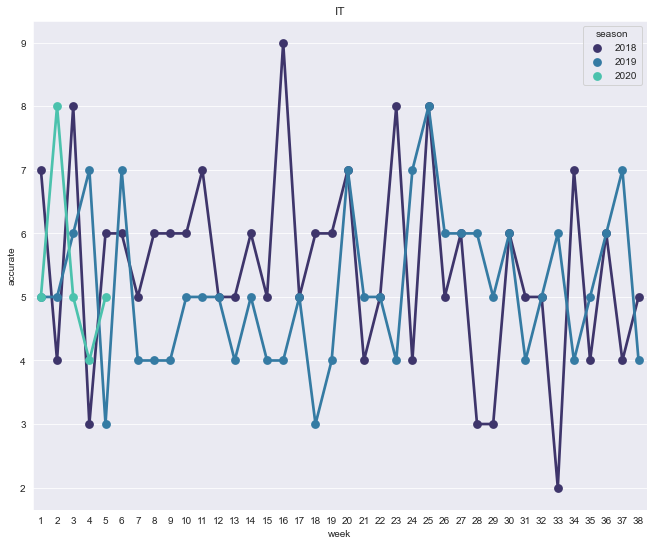

In [166]:
weeks_predictions(df)

Total wrong = 22/49
Error = 0.449


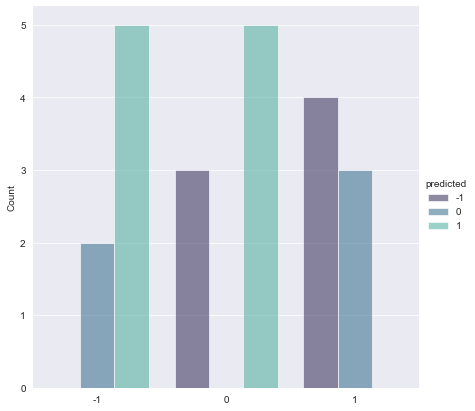

In [167]:
wrong_predictions(df, 2020)

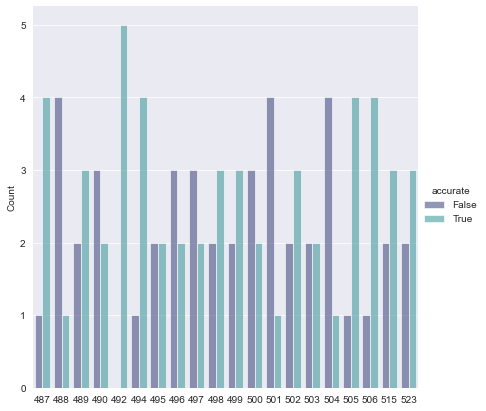

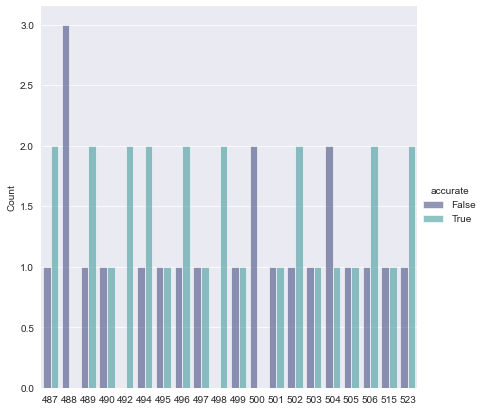

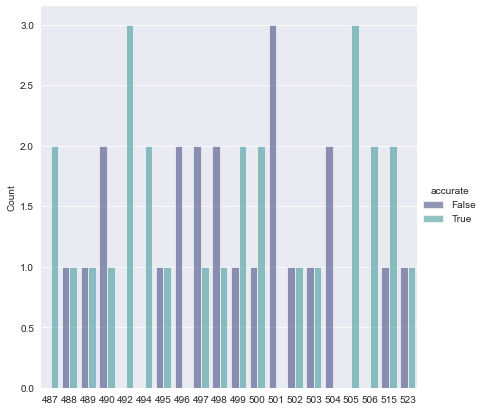

In [168]:
# When playing home or away
teams_predictions(df, 2020, "both")
# When playing home
teams_predictions(df, 2020, "home_team.id")
# When playing away
teams_predictions(df, 2020, "away_team.id")

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='0', clf_to_save='nb_ovo', if_anova='both', log_transform=True)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = custom_test(dct, '8', '3', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='1', clf_to_save='svc_ovo', if_anova=False)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [92]:
"""
    Everything to retrieve the data
"""
global country
country = 'ES'
league = '140'
curr_week = 6
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

0-3
hola
0-2
hola
0-3
hola
1-3
hola
1-3
hola
1-2
hola
0-2
hola
0-2
hola
0-3
hola
0-1
hola
0-1
hola
0-2
hola
0-1
hola
0-1
hola
0-1
hola
0-2
hola
1-3
hola
0-2
0-1
0-2
0-1
0-2
0-3
1-2
0-2
0-2
1-3
1-2
1-3
1-3
0-3
0-2
2-1
hola
3-1
hola
4-2
hola
2-0
hola
2-0
hola
4-0
hola
1-0
hola
6-1
hola
2-1
hola
2-0
hola
1-0
hola
1-0
hola
3-0
hola
4-1
hola
2-0
hola
0-2
0-1
0-2
0-1
0-2
0-3
1-2
0-2
0-2
1-3
1-2
1-3
1-3
0-3
0-2
0-3
hola
0-2
hola
0-3
hola
1-3
hola
1-3
hola
1-2
hola
0-2
hola
0-2
hola
0-3
hola
0-1
hola
0-1
hola
0-2
hola
0-1
hola
0-1
hola
0-1
hola
0-2
hola
1-3
hola
0-2
0-1
0-2
0-1
0-2
0-3
1-2
0-2
0-2
1-3
1-2
1-3
1-3
0-3
0-2
2-1
hola
3-1
hola
4-2
hola
2-0
hola
2-0
hola
4-0
hola
1-0
hola
6-1
hola
2-1
hola
2-0
hola
1-0
hola
1-0
hola
3-0
hola
4-1
hola
2-0
hola
0-2
0-1
0-2
0-1
0-2
0-3
1-2
0-2
0-2
1-3
1-2
1-3
1-3
0-3
0-2
0-3
hola
0-2
hola
0-3
hola
1-3
hola
1-3
hola
1-2
hola
0-2
hola
0-2
hola
0-3
hola
0-1
hola
0-1
hola
0-2
hola
0-1
hola
0-1
hola
0-1
hola
0-2
hola
1-3
hola
2-1
hola
3-1
hola
4-2
hola
2-0


In [93]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 7
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, year_window=year_window, week=week, classifiers=['nb_ovo'])
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
10
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]]
[1, 1, 1, 1, 1, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
20
[[ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]]
[1, 0, 1, 1, 1, 1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
30
[[-1]
 [-1]
 [ 1]
 [ 1]
 [ 0]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]]
[-1, -1, 1, 1, 0, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
40
[[ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]]
[1, -1, 1, -1, 1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
50
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]]
[1, 1, 1, 1, -1, 1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
60
[[ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]
[1, 1, -1, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
70
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]]
[1, 1, 1, -1, 1, 1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
80
[[ 1]
 [-1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]
[1, -1, 0, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
90
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]]
[1, 1, 1, -1, 1, 1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
100
[[-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]
[-1, -1, 1, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
110
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]]
[1, 1, 1, 1, 0, 1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
120
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]]
[1, 1, 1, 1, 1, 1, 1, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
130
[[ 1]
 [ 1]
 [-1]
 [ 0]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]]
[1, 1, -1, 0, -1, 1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
140
[[ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 0]]
[1, 1, -1, 1, 1, 1, 0, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
150
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]]
[1, 1, 1, 1, 0, 1, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
160
[[ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 0]]
[1, 1, -1, 1, 1, 1, -1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
170
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]]
[1, 1, 1, 1, -1, 1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
180
[[ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 0]]
[1, -1, 1, 1, 1, 1, -1, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
190
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]]
[1, 1, 1, 1, 0, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
200
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 0]
 [-1]
 [ 1]]
[1, 1, 1, 1, 1, 1, 0, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
210
[[ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]]
[1, 1, 0, 1, 1, 1, 1, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
220
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 0]
 [-1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]]
[1, 1, 1, -1, 0, -1, 0, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
230
[[ 1]
 [ 0]
 [ 0]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]]
[1, 0, 0, -1, -1, 1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
240
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [-1]
 [ 1]]
[-1, 1, 1, 1, 1, 1, 0, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
250
[[ 1]
 [ 0]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]
[1, 0, 1, -1, 1, -1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
260
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]]
[1, 1, 1, 1, 0, 1, -1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
270
[[ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]
[1, 0, 1, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
280
[[ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 0]
 [ 1]
 [ 1]]
[1, 1, -1, 1, -1, 1, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
290
[[ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 0]]
[1, 0, 1, 1, 1, 1, -1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
300
[[ 1]
 [-1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]]
[1, -1, 1, 0, 1, 1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
310
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]]
[1, 1, 1, 1, 1, 1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
320
[[ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]]
[1, -1, 1, 1, 1, 1, 1, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
330
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [-1]]
[1, 1, 1, 1, 0, 1, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
340
[[-1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [-1]
 [ 1]
 [ 0]]
[-1, 0, 1, 1, 1, 1, 0, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
350
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]]
[1, 1, 1, 1, 0, 1, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
360
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 0]]
[1, 1, 1, -1, 1, 1, -1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
370
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [-1]
 [ 1]
 [ 1]
 [ 0]
 [-1]]
[1, 1, 1, 1, 0, -1, 1, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
380
[[-1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [-1]]
[-1, 0, 1, 1, 1, 1, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
390
[[ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]]
[1, -1, 1, 1, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
400
[[ 0]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]]
[0, -1, 1, 1, 1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
410
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [-1]]
[1, 1, 1, 1, 1, 1, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
420
[[ 0]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]]
[0, 1, 1, 1, -1, -1, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
430
[[ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [-1]]
[1, 1, -1, 1, 1, 1, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
440
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]]
[-1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
450
[[ 1]
 [ 0]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [-1]]
[1, 0, 1, 1, -1, 1, 1, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
460
[[ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [-1]]
[0, 1, 1, 1, 1, 1, 1, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
470
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]]
[-1, 1, 1, 1, 1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
480
[[ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]]
[1, -1, -1, 1, 1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
490
[[ 0]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]]
[0, -1, 1, 1, -1, 1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
500
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 0]
 [ 1]]
[1, 1, 1, -1, 1, 1, 0, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
510
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]]
[-1, 1, 1, 1, -1, 1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
520
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]
 [ 1]
 [-1]
 [ 1]]
[1, 1, 1, 1, -1, 1, 0, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
530
[[-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]]
[-1, 1, -1, -1, 1, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
540
[[ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 0]
 [ 0]
 [ 1]
 [ 1]
 [-1]]
[1, 1, 0, 1, 1, 0, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
550
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]]
[-1, 1, 1, 1, 1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
560
[[ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]]
[1, -1, 1, 1, 1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
570
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]]
[1, 1, 1, 1, 1, 1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
580
[[ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 0]
 [ 1]
 [ 1]]
[1, -1, 1, 1, 1, 0, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
590
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 0]
 [ 1]
 [-1]
 [ 1]]
[-1, 1, 1, 1, 1, 0, 0, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
600
[[ 1]
 [ 0]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]]
[1, 0, 1, -1, 1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
610
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [-1]
 [-1]]
[1, 1, 1, 1, 1, 0, 1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
620
[[ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]]
[1, -1, -1, 1, 1, 1, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
630
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 0]
 [ 1]]
[1, 1, 1, -1, -1, 1, -1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
640
[[ 0]
 [ 1]
 [ 0]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]]
[0, 1, 0, 1, 1, -1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
650
[[ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]
 [ 0]
 [ 0]]
[1, -1, 1, 1, 1, -1, 1, 0, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
660
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]]
[-1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
670
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]
 [-1]
 [-1]]
[1, 1, 1, 1, 1, -1, 1, 0, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
680
[[ 0]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 1]
 [ 1]]
[0, 1, -1, 1, 1, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
690
[[ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [-1]]
[1, 1, 1, 1, 0, 0, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
700
[[ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]]
[1, 0, 1, 1, 1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
710
[[ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 0]]
[0, 1, 1, 1, 1, 1, -1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
720
[[ 1]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 0]
 [ 0]
 [ 1]]
[1, 0, 1, 1, 1, -1, 1, 0, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
730
[[ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]]
[0, 1, 1, 1, 1, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
740
[[ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [-1]
 [ 1]]
[1, -1, 1, 1, 1, 1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
750
[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]]
[0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
760
[[ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 0]
 [-1]
 [ 1]]
[1, 1, -1, -1, 1, 1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
769
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]]
[1, 1, 1, -1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
778
[[ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]]
[1, 1, -1, 1, 1, 1, -1, 

Total accurate = 382/817
Accuracy = 0.468


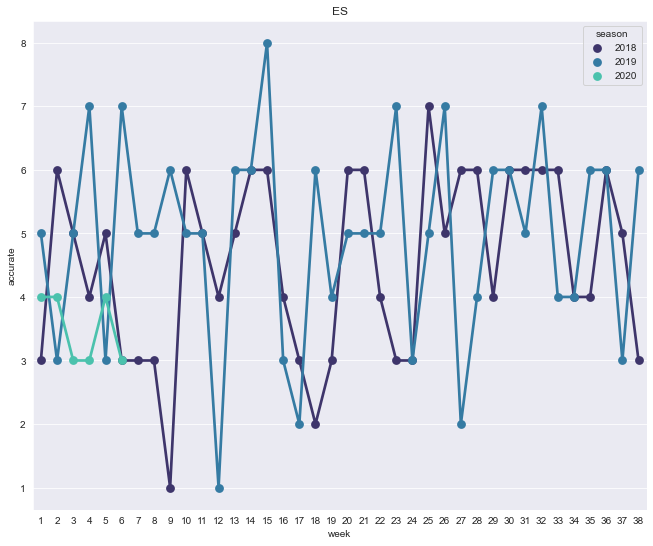

In [94]:
weeks_predictions(df)

Total wrong = 36/57
Error = 0.632


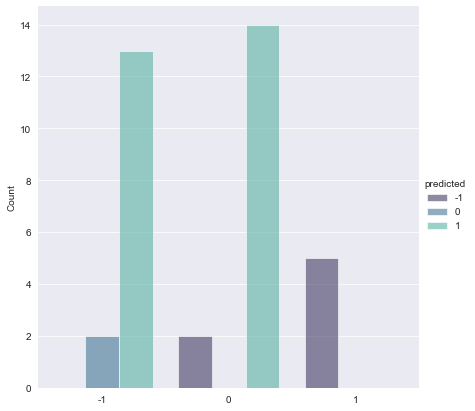

In [95]:
wrong_predictions(df, 2020)

In [73]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 7
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
10
[[ 1  1  1  1]
 [ 1  0 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1  0  0]
 [ 1  0  1  1]
 [-1  0 -1 -1]
 [ 1  0 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  0  1]]
[1, 1, 1, 1, 1, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
20
[[ 1 -1  0  0]
 [ 0  0  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  0]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]
[0, 1, 0, 1, 1, 1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
30
[[-1 -1  1  1]
 [-1 -1  1  1]
 [ 1  1  1  1]
 [ 1  1  0 -1]
 [ 0  0 -1 -1]
 [-1 -1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  0  1]
 [ 1  1 -1 -1]]
[0, 0, 1, -1, -1, 0, 1, 0, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
40
[[ 1  1  1  1]
 [-1  0  1  0]
 [ 1  0  1  1]
 [-1 -1  1 -1]
 [ 1  1  0  1]
 [ 1  1  0  1]
 [ 1  1  0  0]
 [ 1  1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  0]]
[1, 0, 1, -1, 1, 1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
50
[[ 1  1  0 -1]
 [ 1  1  0  0]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1 -1  1  1]
 [ 1  1  1  0]
 [-1  1 -1 -1]
 [-1  1  0  0]
 [ 1  1  0  1]
 [ 1  0  1  1]]
[-1, 1, 1, 0, 0, 1, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
60
[[ 1  1  0  1]
 [ 1  0  0 -1]
 [-1 -1 -1 -1]
 [ 1  1  0  1]
 [ 1  1  1 -1]
 [ 1 -1  1  1]
 [ 1  1  1  0]
 [ 1  1 -1  1]
 [ 1  1  0  1]
 [-1  1 -1 -1]]
[1, 0, -1, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
70
[[ 1  0 -1 -1]
 [ 1  1  0 -1]
 [ 1  1  0  1]
 [-1 -1 -1  0]
 [ 1  0  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [-1  1 -1 -1]
 [ 1  1  1  1]
 [ 1 -1  0  1]]
[1, -1, 1, -1, 1, 1, -1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
80
[[ 1 -1 -1 -1]
 [-1 -1  0 -1]
 [ 0  0 -1 -1]
 [ 1  0  0  0]
 [ 1  0 -1 -1]
 [ 1  1  1  1]
 [ 1  0  1  1]
 [ 1  1  0 -1]
 [ 1  1  1  1]
 [-1  1  0  0]]
[-1, -1, -1, 0, 1, 1, 1, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
90
[[ 1  1  0 -1]
 [ 1  1 -1 -1]
 [ 1  0  0 -1]
 [-1 -1  1  1]
 [ 1  1  0  0]
 [ 1  0  1  1]
 [-1  0  0 -1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [-1 -1  1  0]]
[-1, 0, 0, 0, 1, 1, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
100
[[-1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  0 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [-1  1 -1 -1]]
[1, -1, 1, 1, 1, 0, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
110
[[ 1  1  0 -1]
 [ 1  1  1  0]
 [ 1  1  1  1]
 [ 1  1  0  1]
 [ 0  0  0  0]
 [ 1  1  0  0]
 [-1  1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]]
[-1, 1, 1, 1, 0, 1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
120
[[ 1  1  0  1]
 [ 1  0 -1 -1]
 [ 1  0 -1 -1]
 [ 1  0  1  1]
 [ 1 -1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1  0 -1 -1]
 [ 1  1  1  1]
 [ 0  1 -1  0]]
[1, 1, 1, 1, 1, 1, 0, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
130
[[ 1  1  1  1]
 [ 1  1  0  1]
 [-1 -1  1  1]
 [ 0  0  1  1]
 [-1 -1 -1 -1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1 -1]
 [ 0 -1 -1 -1]
 [ 1  1  1  1]]
[1, 1, 0, 1, -1, 0, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
140
[[ 1  1 -1 -1]
 [ 1 -1  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1  0 -1]
 [ 0  1  1  1]
 [ 1 -1  0  1]
 [ 1  1  1  1]
 [ 0  1 -1 -1]]
[0, 1, -1, 1, 1, -1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
150
[[ 1  1  0  0]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  0  0  0]
 [ 0  0 -1 -1]
 [ 1  0  1  1]
 [ 1  0  1 -1]
 [-1 -1 -1 -1]
 [-1 -1  1 -1]
 [ 1  1  0  1]]
[1, 1, 1, 0, -1, 1, -1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
160
[[ 1  0 -1 -1]
 [ 1  0 -1 -1]
 [-1 -1  0  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  0  0 -1]
 [-1 -1  0 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 0  1 -1 -1]]
[1, 1, 1, 1, 1, 0, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
170
[[ 1 -1  1  0]
 [ 1  0  0  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1  0  0]
 [ 1  1  0 -1]
 [ 1  0 -1 -1]
 [ 1  1 -1 -1]
 [ 0 -1 -1 -1]
 [ 1  1  1  1]]
[-1, 1, 1, 1, -1, -1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
180
[[ 1  0 -1 -1]
 [-1  0 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1 -1  0 -1]
 [ 1  1  0  1]
 [-1 -1  1  1]
 [ 0  1 -1 -1]]
[1, -1, 1, 1, 1, 0, -1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
190
[[ 1  1 -1 -1]
 [ 1  0 -1 -1]
 [ 1 -1  1  1]
 [ 1  1  1  1]
 [ 0  0  0  1]
 [ 1  0 -1 -1]
 [-1 -1  1  0]
 [ 1  1  1  1]
 [-1 -1  0  0]
 [ 1  1  0  0]]
[0, 1, 1, 1, 0, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
200
[[ 1  1 -1 -1]
 [ 1 -1  0 -1]
 [ 1  1  0  1]
 [ 1  1 -1 -1]
 [ 1  0  1  1]
 [ 1  1  1  1]
 [ 0  0 -1 -1]
 [ 0  1 -1 -1]
 [-1 -1  1  1]
 [ 1  0  1  1]]
[0, 1, 1, 0, 1, 1, -1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
210
[[ 1  1  1  1]
 [ 1  0 -1 -1]
 [ 0  0  1  1]
 [ 1  1 -1 -1]
 [ 1  0  1 -1]
 [ 1  1  1  1]
 [ 1 -1 -1 -1]
 [-1 -1  1  1]
 [ 1  1  1  1]
 [ 0 -1 -1 -1]]
[1, 1, 1, 0, -1, 1, -1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
220
[[ 1  1  0 -1]
 [ 1  1  0  0]
 [ 1 -1  1  1]
 [-1 -1  0 -1]
 [ 0  1  1  1]
 [-1 -1  1  1]
 [ 0  0 -1 -1]
 [ 1  1 -1 -1]
 [ 1 -1  1  1]
 [ 1  1 -1  0]]
[-1, 1, 1, -1, 1, 0, -1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
230
[[ 1  1 -1  0]
 [ 0  0  0 -1]
 [ 0  0  0  0]
 [-1 -1  1  0]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 1 -1 -1 -1]]
[-1, 0, 0, 1, -1, 1, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
240
[[-1 -1  1  0]
 [ 1  1  0 -1]
 [ 1  0  1  1]
 [ 1  1  0  1]
 [ 1  1  0 -1]
 [ 1  0  1  1]
 [ 0  0  0 -1]
 [ 1  1 -1  0]
 [-1 -1  1  1]
 [ 1  1  0  0]]
[1, -1, 1, 1, -1, 1, 0, -1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
250
[[ 1  0 -1 -1]
 [ 0 -1  0  0]
 [ 1  1  0 -1]
 [-1 -1  1  1]
 [ 1  1  1  0]
 [-1 -1  0  0]
 [ 1  1 -1  0]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]
[1, 0, -1, 0, 1, -1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
260
[[ 1  1  1  1]
 [ 1  1  0  0]
 [ 1  1 -1 -1]
 [ 1  1 -1  0]
 [ 0  0  0 -1]
 [ 1  0 -1 -1]
 [-1  0  1  1]
 [-1  1  1 -1]
 [-1 -1  0  1]
 [ 1  1  1  1]]
[1, 1, 0, -1, 0, 1, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
270
[[ 1  1  0  0]
 [ 0  0 -1  0]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  0  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [-1 -1  1 -1]]
[1, 0, 0, 1, 1, 0, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
280
[[ 1  0  0 -1]
 [ 1  1  0 -1]
 [-1 -1 -1 -1]
 [ 1  1  0 -1]
 [-1 -1  0 -1]
 [ 1  1  0  0]
 [-1  1  1  1]
 [ 0 -1  1  1]
 [ 1  1  1  1]
 [ 1  1  1  1]]
[0, -1, -1, -1, -1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
290
[[ 1  1  0  0]
 [ 0  0 -1 -1]
 [ 1  1  1  1]
 [ 1 -1  1  1]
 [ 1 -1  1  1]
 [ 1  1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  0]
 [ 0 -1 -1 -1]]
[1, -1, 1, 1, 1, 0, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
300
[[ 1 -1 -1 -1]
 [-1 -1  1  1]
 [ 1  1  0  0]
 [ 0  0  0 -1]
 [ 1  1  1 -1]
 [ 1  0  0 -1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 0  1 -1 -1]
 [ 1  1  1  1]]
[-1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
310
[[ 1  1  1 -1]
 [ 1  1  0  1]
 [ 1  0 -1 -1]
 [ 1  0  1  1]
 [ 1  0  1  1]
 [ 1  1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]
[1, 1, 1, 1, 1, 0, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
320
[[ 1  1  1  1]
 [-1 -1  1  0]
 [ 1  1  0  0]
 [ 1  1  0 -1]
 [ 1  1  1  1]
 [ 1  1  1 -1]
 [ 1  0  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 0 -1 -1 -1]]
[1, 1, 1, -1, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
330
[[ 1  1 -1 -1]
 [ 1 -1  0  0]
 [ 1  1  0  1]
 [ 1  1 -1 -1]
 [ 0  0 -1 -1]
 [ 1  1  1  1]
 [ 1 -1  1  0]
 [ 0  0  0  0]
 [ 1  1  0  1]
 [-1 -1  1  1]]
[0, 0, 1, 0, -1, 1, -1, 0, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
340
[[-1 -1 -1 -1]
 [ 0  0 -1  0]
 [ 1  1  0  0]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1  0]
 [ 0  0  0 -1]
 [-1 -1  1  1]
 [ 1  1  1  1]
 [ 0  0 -1 -1]]
[-1, 0, 1, 1, 1, -1, 0, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
350
[[ 1  1  0  0]
 [ 1  1  1  1]
 [ 1  1  0 -1]
 [ 1  1  0  1]
 [ 0  0  0  0]
 [ 1  0 -1 -1]
 [ 1  0  1  0]
 [-1  1  1  1]
 [-1 -1  1  1]
 [ 1  1 -1 -1]]
[1, 1, -1, 1, 0, 1, 1, 1, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
360
[[ 1  0  0  0]
 [ 1  0 -1 -1]
 [ 1  1  1  1]
 [-1 -1  0 -1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1 -1  1  1]
 [ 0  1 -1 -1]]
[0, 1, 1, -1, 1, 0, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
370
[[ 1  0  0  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1  1]
 [ 0  0 -1 -1]
 [-1  1  0  0]
 [ 1  1  0 -1]
 [ 1  1  0  0]
 [ 0  1 -1 -1]
 [-1 -1  1  1]]
[1, 1, 1, 1, -1, 0, -1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
380
[[-1 -1 -1 -1]
 [ 0  0  0 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  0  0  0]
 [ 0  1 -1 -1]
 [ 1  1  1  1]
 [ 1 -1  1  1]
 [-1 -1 -1 -1]]
[-1, 0, 1, 1, 1, 0, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
390
[[ 1  1 -1  0]
 [-1  0  1  1]
 [ 1  1  0  1]
 [ 1  1  0  1]
 [ 1  0  0  1]
 [ 1  1  0 -1]
 [ 1  1  0  1]
 [-1 -1  1 -1]
 [ 1 -1 -1 -1]
 [-1  0  1  1]]
[-1, -1, 1, 1, 1, -1, 1, -1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
400
[[ 0  1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  0 -1]
 [ 1  1 -1 -1]
 [-1 -1  1  1]
 [ 1  1  0  0]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [ 1  1 -1  0]]
[1, -1, 1, -1, 0, 0, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
410
[[ 1 -1  0 -1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  0  1]
 [-1 -1 -1 -1]]
[1, 1, 0, 1, 1, 0, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
420
[[ 0 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [-1 -1  0 -1]
 [-1  1  0 -1]
 [ 1  0 -1 -1]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [ 0  1 -1 -1]]
[-1, 1, 1, 1, -1, 1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
430
[[ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  1 -1  0]
 [ 1  1  0  0]
 [ 1  1 -1  0]
 [ 1  1  0  1]
 [ 0  0 -1 -1]
 [ 1  0  1  1]
 [-1  1 -1  0]]
[1, 1, -1, -1, 1, -1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
440
[[-1  0 -1 -1]
 [ 1  1  0  1]
 [ 1  0  1  1]
 [ 1  1  1  0]
 [ 1 -1 -1 -1]
 [ 1  0 -1 -1]
 [ 1  1  1  1]
 [ 1  1  0  1]
 [ 1  0  0  1]
 [ 0  0 -1 -1]]
[-1, 1, 1, 1, -1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
450
[[ 1  1  1  1]
 [ 0  1 -1 -1]
 [ 1  1  0  0]
 [ 1  1  1  1]
 [-1 -1  0  0]
 [ 1  1 -1  0]
 [ 1  1  0  1]
 [ 1  1 -1  0]
 [ 0  0  0 -1]
 [-1 -1 -1 -1]]
[1, 1, 1, 1, -1, -1, 1, -1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
460
[[ 0  0  1  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1 -1  1 -1]
 [ 1  0 -1 -1]
 [ 1  1  0  0]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [ 0  1 -1 -1]
 [-1 -1 -1 -1]]
[1, 1, 1, 0, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
470
[[-1 -1  1  0]
 [ 1  1 -1 -1]
 [ 1 -1 -1 -1]
 [ 1  0  0 -1]
 [ 1  1  0  1]
 [ 1  1  0  0]
 [ 1  1  0  1]
 [-1 -1  0 -1]
 [ 1  1  0  0]
 [ 1  1  1  1]]
[1, 0, -1, 0, 1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
480
[[ 1  1  1  1]
 [-1 -1 -1  0]
 [-1 -1  1  1]
 [ 1  0  1  1]
 [ 1  1  0  0]
 [ 1 -1  1  1]
 [ 1  1  0 -1]
 [ 1  1  1  0]
 [-1  1 -1 -1]
 [ 1  1  0  0]]
[1, -1, 0, 1, 1, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
490
[[ 0  0 -1 -1]
 [-1 -1  1  1]
 [ 1  1  0  0]
 [ 1  1  0  0]
 [-1 -1  0 -1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  0  1]
 [ 0  0 -1 -1]
 [ 1  0  1  1]]
[-1, 0, 1, 1, -1, 0, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
500
[[ 1  1  1  1]
 [ 1  0 -1 -1]
 [ 1  0 -1 -1]
 [-1 -1 -1 -1]
 [ 1 -1  0  1]
 [ 1  1  0  1]
 [ 0 -1  0  0]
 [ 1  1  1  1]
 [ 0  0  1  1]
 [ 1  1  0 -1]]
[1, 1, 1, -1, -1, 1, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
510
[[-1 -1 -1 -1]
 [ 1  0  1  1]
 [ 1  1  0  1]
 [ 1  1 -1  0]
 [-1 -1  0  0]
 [ 1  0 -1 -1]
 [ 1  1  1  1]
 [ 1  0 -1 -1]
 [ 1 -1 -1 -1]
 [ 1  1  1  1]]
[-1, 1, 1, -1, -1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
520
[[ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  0]
 [-1 -1 -1 -1]
 [ 1  0  1  1]
 [ 0  0  0 -1]
 [ 1  1  1  1]
 [-1 -1  0 -1]
 [ 1  1 -1  0]]
[1, 1, 0, 1, -1, 1, 0, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
530
[[-1 -1 -1  1]
 [ 1  1  1  1]
 [-1 -1  1 -1]
 [-1 -1  0 -1]
 [ 1  1  0  1]
 [ 1  1  0  0]
 [ 1  1  0  0]
 [ 0  0 -1 -1]
 [ 1  0  0  1]
 [ 1  1  1  1]]
[-1, 1, -1, -1, 1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
540
[[ 1  1  0  1]
 [ 1  1  1  1]
 [ 0  0 -1 -1]
 [ 1  1  1  1]
 [ 1  0  0  0]
 [ 0  0 -1 -1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1 -1 -1 -1]]
[1, 1, -1, 1, 0, -1, 0, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
550
[[-1 -1  1  1]
 [ 1  1 -1  0]
 [ 1  1  0 -1]
 [ 1  1  0  0]
 [ 1  1  1  1]
 [ 1  1  0  0]
 [ 1  1  0  0]
 [-1  0 -1 -1]
 [ 1 -1  0  1]
 [ 1 -1  0  0]]
[0, -1, -1, 1, 1, 1, 1, -1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
560
[[ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  0  1  1]
 [ 1  1 -1 -1]
 [ 1  1  0  1]
 [-1  1 -1  0]
 [ 1  1 -1 -1]]
[1, -1, 1, 1, 0, 1, 0, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
570
[[ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1  0  1]
 [ 1  1  0 -1]
 [ 1  1  0  0]
 [ 1  1  0  1]
 [-1 -1 -1 -1]
 [-1 -1  0  0]
 [ 1  1  1  1]
 [ 1  1  0 -1]]
[1, 1, 1, -1, 1, 1, -1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
580
[[ 1  1  1  1]
 [-1  0  0  0]
 [ 1  1  0 -1]
 [ 1  1  1  0]
 [ 1  1 -1 -1]
 [ 0  1 -1 -1]
 [ 1  1  0 -1]
 [ 0  1 -1 -1]
 [ 1 -1  0  1]
 [ 1  1  0  0]]
[1, 0, -1, 1, 0, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
590
[[-1 -1  0  1]
 [ 1  1  0 -1]
 [ 1  0  0 -1]
 [ 1  1  0  0]
 [ 1  1  0  0]
 [ 0  0  0  0]
 [ 0  0  1  1]
 [ 1  1  1  1]
 [-1 -1  0 -1]
 [ 1  1  0  0]]
[1, -1, 0, 1, 1, 0, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
600
[[ 1  1  1  1]
 [ 0 -1 -1 -1]
 [ 1  1  1  1]
 [-1  1  1  1]
 [ 1  1  1  1]
 [-1 -1  0  0]
 [ 1  1 -1 -1]
 [ 1  1 -1 -1]
 [ 1  1 -1  0]
 [ 1  1  0  1]]
[1, -1, 1, 1, 1, -1, 0, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
610
[[ 1 -1  1  1]
 [ 1  1  0 -1]
 [ 1  0  0 -1]
 [ 1  1  0 -1]
 [ 1  1  0  0]
 [ 0  0  1  1]
 [ 1 -1  0  1]
 [ 1  1  1  1]
 [-1 -1  0 -1]
 [-1 -1 -1 -1]]
[1, -1, 0, -1, 1, 1, -1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
620
[[ 1  1  1  1]
 [-1 -1 -1 -1]
 [-1  0  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1 -1  0 -1]
 [ 1  1 -1 -1]
 [ 1  0  1  1]
 [ 1  0  0  1]]
[1, -1, -1, 0, 1, 0, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
630
[[ 1  1  1  1]
 [ 1  1  1  0]
 [ 1 -1  0  0]
 [-1 -1  0 -1]
 [-1 -1  1 -1]
 [ 1  1  0 -1]
 [-1 -1 -1 -1]
 [ 1  0  1  1]
 [ 0  1  1  1]
 [ 1  1  0 -1]]
[1, 1, 0, -1, -1, -1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
640
[[ 0 -1 -1  0]
 [ 1  1  1  1]
 [ 0  1 -1 -1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1  1  0  0]
 [ 1  1 -1  0]
 [ 0  0  0 -1]
 [ 1 -1  0  1]
 [ 1  1  1  1]]
[-1, 1, 1, 1, 0, 0, -1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
650
[[ 1  1  0  1]
 [-1 -1  1  1]
 [ 1  1  1 -1]
 [ 1  1  1  1]
 [ 1  1  0  0]
 [-1 -1 -1 -1]
 [ 1  1 -1 -1]
 [ 0  0 -1 -1]
 [ 0  1 -1 -1]
 [ 0  0  1  1]]
[1, 0, 1, 1, 1, -1, 0, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
660
[[-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  0 -1]
 [ 1  1  1  1]
 [ 1  1  0 -1]
 [ 1  0  0  1]
 [ 0  0  0 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]]
[-1, 1, 0, -1, 1, -1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
670
[[ 1  1  1  1]
 [ 1  1  1  0]
 [ 1  1  0 -1]
 [ 1  1  0  0]
 [ 1  0  0 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 0  0  1  1]
 [-1  1 -1 -1]
 [-1  0 -1 -1]]
[1, 1, -1, 1, 0, -1, 1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
680
[[ 0  0  0 -1]
 [ 1  1  1  1]
 [-1 -1  0 -1]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [ 1  1  0  0]
 [ 1  1  0 -1]
 [ 0  0  0 -1]
 [ 1  0  1  0]
 [ 1 -1  1  1]]
[0, 1, -1, 1, 1, 1, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
690
[[ 1 -1  0  1]
 [ 1  1  1  1]
 [ 1  1  0  0]
 [ 1  1 -1  0]
 [ 0  1 -1 -1]
 [ 0  0 -1 -1]
 [ 1  0 -1  0]
 [ 1  1  1  1]
 [ 1  1  0 -1]
 [-1  0 -1 -1]]
[-1, 1, 1, -1, 1, -1, 0, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
700
[[ 1  1  1  1]
 [ 0  1 -1 -1]
 [ 1  1  0 -1]
 [ 1  1  0  1]
 [ 1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1  0 -1]
 [ 1  0  0 -1]
 [ 1  1 -1 -1]]
[1, 1, -1, 1, -1, 1, 1, -1, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
710
[[ 0  0 -1 -1]
 [ 1  1  1  1]
 [ 1 -1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  0 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 0  1 -1 -1]]
[-1, 1, 1, 1, 0, 1, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
720
[[ 1  1  0  1]
 [ 0  1  1  0]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [-1 -1  0  0]
 [ 1  1  1  1]
 [ 0  0  0 -1]
 [ 0  1  0 -1]
 [ 1  1 -1  0]]
[1, 1, 1, 0, 1, -1, 1, 0, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
730
[[ 0  0 -1 -1]
 [ 1  1  0  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [ 1  1  0  0]
 [-1 -1 -1 -1]
 [ 1  1  0  1]
 [-1 -1  0 -1]
 [ 1  1  1  0]]
[-1, 1, 1, 1, 0, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
740
[[ 1  1  1  1]
 [-1 -1  0 -1]
 [ 1  1  0  1]
 [ 1  1  1  0]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 0  0  0 -1]
 [-1 -1 -1 -1]
 [ 1  1 -1 -1]]
[1, -1, 1, 1, 1, 1, 1, 0, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
750
[[ 0  0 -1 -1]
 [ 1  1  1  1]
 [ 1  1  0  1]
 [ 1  1  0  0]
 [ 1  1  0  0]
 [ 1  1  0  0]
 [ 1  1 -1 -1]
 [ 1  1  1  1]
 [ 0  0 -1 -1]
 [ 1 -1  0  0]]
[-1, 1, 1, 1, 1, 1, 0, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
760
[[ 1  1  1  1]
 [ 1 -1 -1  0]
 [-1  1 -1 -1]
 [-1 -1  0  0]
 [ 1  1  0 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [ 0  0  0 -1]
 [-1  1  0  1]
 [ 1  1  1  1]]
[1, 1, -1, -1, -1, 1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
769
[[ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  0]
 [ 1  1  0 -1]
 [-1  0  1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]
[1, 1, 0, -1, 1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies

Total accurate = 357/817
Accuracy = 0.437


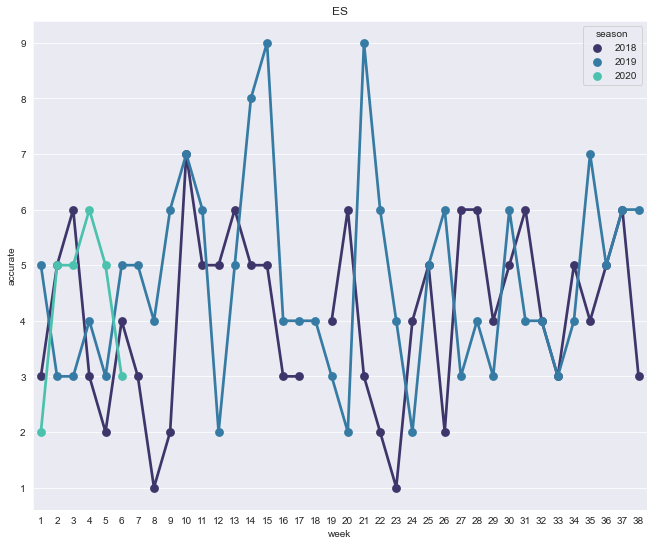

In [74]:
weeks_predictions(df)

Total wrong = 31/57
Error = 0.544


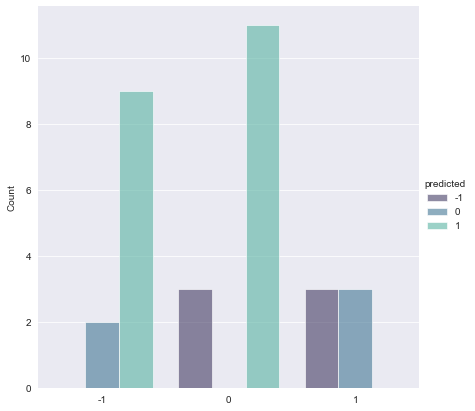

In [75]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 7
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='0', clf_to_save='nb_ovo', if_anova='both', log_transform=True)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 7
accuracy, df = custom_test(dct, '8', '3', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='1', clf_to_save='svc_ovo', if_anova=False)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [96]:
"""
    Everything to retrieve the data
"""
global country
country = 'DE'
league = '78'
curr_week = 4
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

1-3
hola
1-3
hola
0-1
hola
1-3
hola
1-4
hola
2-3
hola
1-4
hola
1-4
hola
0-2
hola
1-3
hola
0-1
1-4
1-4
2-3
2-3
1-3
0-2
1-4
1-3
0-1
1-3
1-3
3-1
hola
8-0
hola
2-1
hola
4-1
hola
2-1
hola
4-0
hola
1-0
hola
1-0
hola
4-0
hola
2-0
hola
4-0
hola
0-1
1-4
1-4
2-3
2-3
1-3
0-2
1-4
1-3
0-1
1-3
1-3
1-3
hola
1-3
hola
0-1
hola
1-3
hola
1-4
hola
2-3
hola
1-4
hola
1-4
hola
0-2
hola
1-3
hola
0-1
1-4
1-4
2-3
2-3
1-3
0-2
1-4
1-3
0-1
1-3
1-3
3-1
hola
8-0
hola
2-1
hola
4-1
hola
2-1
hola
4-0
hola
1-0
hola
1-0
hola
4-0
hola
2-0
hola
4-0
hola
0-1
1-4
1-4
2-3
2-3
1-3
0-2
1-4
1-3
0-1
1-3
1-3
1-3
hola
1-3
hola
0-1
hola
1-3
hola
1-4
hola
2-3
hola
1-4
hola
1-4
hola
0-2
hola
1-3
hola
3-1
hola
8-0
hola
2-1
hola
4-1
hola
2-1
hola
4-0
hola
1-0
hola
1-0
hola
4-0
hola
2-0
hola
4-0
hola
0-1
hola
1-4
hola
1-4
hola
2-3
hola
2-3
hola
1-3
hola
0-2
hola
1-4
hola
1-3
hola
0-1
hola
1-3
hola
1-3
hola
0-1
hola
1-4
hola
1-4
hola
2-3
hola
2-3
hola
1-3
hola
0-2
hola
1-4
hola
1-3
hola
0-1
hola
1-3
hola
1-3
hola
1-4
hola
1-2
hola
0-5
hol

In [103]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 5
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, classifiers=['rforest_p', 'svc_ovo_p'], year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
9


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  1]
 [ 0  0]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1  0]
 [ 1 -1]]
[1, 1, 0, -1, -1, -1, 1, -1, 0]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
18


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1]
 [-1  0]
 [-1 -1]
 [ 0  0]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 0  0]
 [ 1 -1]]
[1, -1, -1, 0, 1, 1, -1, 0, 0]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
27


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [-1  0]
 [-1  0]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]]
[1, -1, -1, -1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
36


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  1]
 [ 1  1]
 [ 1  0]
 [ 1  1]
 [-1 -1]
 [ 1  0]
 [ 1  1]
 [-1 -1]]
[1, 1, 1, 1, 1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
45


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1]
 [-1 -1]
 [ 0  0]
 [-1 -1]
 [ 1  1]
 [ 0  0]
 [ 1  1]
 [ 0  1]
 [-1 -1]]
[1, -1, 0, -1, 1, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
54


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [ 0  0]
 [ 1  1]
 [-1 -1]]
[1, -1, 1, 1, -1, -1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
63


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [-1  0]
 [-1 -1]
 [-1 -1]
 [-1  0]
 [ 1  1]
 [-1  1]
 [ 1  1]
 [ 1  1]]
[1, -1, -1, -1, -1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


72
[[ 1  1]
 [ 0  0]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [-1  0]
 [ 1  1]
 [ 1  1]
 [-1 -1]]
[1, 0, 1, 1, -1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
81


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1 -1]
 [ 0  0]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [-1  0]
 [-1 -1]]
[-1, 0, 1, 1, 1, -1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
90


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1]
 [ 1  1]
 [ 0  0]
 [ 0  1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1  0]
 [ 1  1]]
[-1, 1, 0, 1, -1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
99


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1 -1]
 [ 0 -1]
 [ 0  0]
 [ 1  1]
 [ 1  0]
 [ 0  0]
 [ 1  1]
 [-1  1]
 [ 1  1]]
[-1, -1, 0, 1, 1, 0, 1, 0, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
108


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [-1  0]
 [ 1  0]
 [ 0 -1]
 [-1  0]]
[1, 1, -1, 1, -1, -1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
117


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1]
 [ 1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [ 1  0]
 [-1  0]
 [ 1  1]
 [-1 -1]]
[-1, 0, 1, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
126


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1  0]
 [ 1  0]
 [ 1  1]]
[1, 1, -1, -1, -1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
135


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1]
 [ 1  0]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  0]
 [ 1  1]
 [ 1  1]
 [ 0  0]]
[-1, 1, 1, -1, 1, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
144


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 0 -1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 0  1]
 [ 1  1]]
[1, -1, 1, -1, -1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
153


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [ 1 -1]
 [ 1  1]
 [ 1  1]
 [-1 -1]]
[1, -1, -1, -1, 1, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
162


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 0 -1]
 [ 1  1]
 [ 0 -1]]
[1, -1, -1, 1, -1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
171


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1]
 [-1  0]
 [-1 -1]
 [-1 -1]
 [ 0  0]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  0]]
[1, -1, -1, -1, 0, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
180


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  0]
 [ 1  1]
 [-1 -1]]
[1, 1, -1, 1, 1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
189


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 0  0]
 [-1 -1]
 [ 1  1]
 [ 1  0]
 [ 0  0]
 [ 0 -1]
 [-1 -1]
 [ 1  0]]
[1, 0, -1, 1, 1, 0, -1, -1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
198


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  1]
 [-1 -1]
 [ 0  0]
 [-1  0]
 [ 0 -1]]
[1, 1, 1, 1, 1, -1, 0, -1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
207


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 0 -1]
 [ 1  1]
 [ 1  0]]
[1, -1, -1, 1, -1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
216


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  0]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [ 0 -1]
 [-1 -1]
 [ 1  1]
 [ 0  1]]
[1, 1, 1, -1, -1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
225


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [ 1  0]
 [ 1  0]
 [ 1  1]
 [ 1  1]]
[1, -1, -1, -1, 1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
234


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  1]
 [-1  0]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [ 1  0]
 [ 1  1]]
[1, 1, -1, 1, 1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
243


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1]
 [-1 -1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 0 -1]
 [ 1  1]
 [ 0 -1]]
[-1, -1, 1, -1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
252


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  1]
 [-1 -1]
 [ 0  0]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]]
[1, 1, -1, 0, -1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
261


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1]
 [ 1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  0]]
[-1, 0, 1, 1, 1, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
270


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1]
 [ 1  1]
 [-1 -1]
 [-1  0]
 [-1 -1]
 [-1 -1]
 [ 1  0]
 [ 1  0]
 [ 1  1]]
[1, 1, -1, -1, -1, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
279


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  0]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [ 1  0]
 [-1 -1]]
[-1, 1, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
288


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1  1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [ 0  0]
 [ 1  1]
 [-1 -1]]
[0, 1, 1, 1, -1, -1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
297


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [-1 -1]
 [ 1  1]
 [ 0 -1]
 [ 0 -1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 0 -1]]
[1, -1, 1, -1, -1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
306


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 0 -1]
 [-1  0]
 [ 1  1]
 [-1 -1]
 [ 1  0]]
[1, -1, 1, 1, -1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
315


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1]
 [ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [ 1  0]
 [-1 -1]]
[1, 1, -1, -1, -1, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
324
[[ 0  0]
 [-1 -1]
 [ 0 -1]
 [ 1  0]
 [-1 -1]
 [ 1  1]
 [ 1  0]
 [ 1  1]
 [ 1  1]]
[0, -1, -1, 1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
333
[[ 1  0]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  0]
 [ 1 -1]
 [-1 -1]
 [-1 -1]]
[1, 1, 1, -1, 1, 1, 0, -1, -1]
Train Method
Pl

Test Method
Current season only median
Applies pezzali to test set
486
[[ 1  1]
 [-1 -1]
 [ 1  1]
 [ 1  0]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]
 [-1 -1]]
[1, -1, 1, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
495
[[ 0 -1]
 [ 1  1]
 [ 0 -1]
 [ 1 -1]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [ 1  1]]
[-1, 1, -1, 0, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
504
[[-1 -1]
 [ 1  1]
 [ 1  0]
 [ 1  1]
 [ 1  1]
 [ 1  1]
 [ 0 

Total accurate = 311/648
Accuracy = 0.480


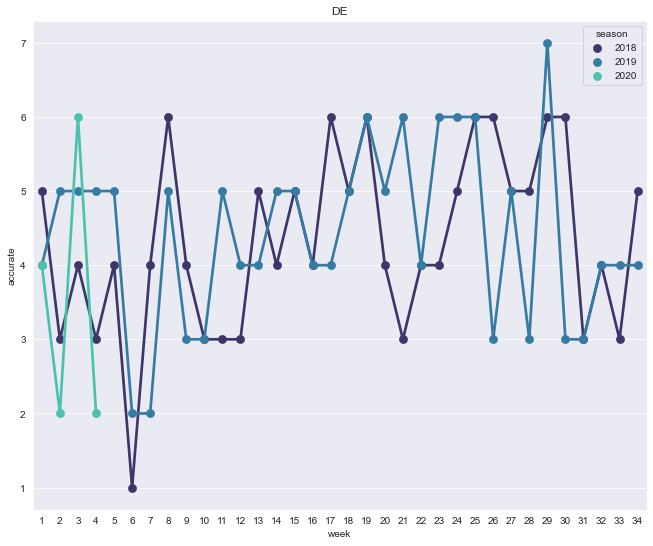

In [104]:
weeks_predictions(df)

Total wrong = 22/36
Error = 0.611


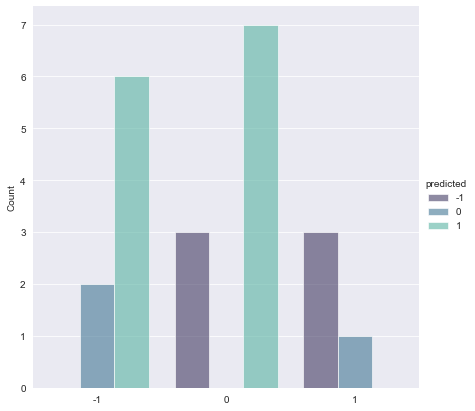

In [105]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 5
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='0', clf_to_save='nb_ovo', if_anova='both', log_transform=True)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 5
accuracy, df = custom_test(dct, '8', '3', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='1', clf_to_save='svc_ovo', if_anova=False)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [169]:
"""
    Everything to retrieve the data
"""
global country
country = 'GB'
league = '39'
curr_week = 5
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

0-3
hola
2-5
hola
1-3
hola
0-3
hola
1-4
hola
1-6
hola
0-1
hola
0-1
hola
0-3
hola
0-2
hola
1-3
hola
1-2
hola
0-1
hola
0-3
hola
2-5
hola
0-2
hola
0-2
hola
0-1
hola
0-3
1-3
0-3
0-2
1-4
0-3
1-2
0-2
1-3
0-3
2-5
0-1
0-3
1-3
0-2
1-6
7-2
hola
1-0
hola
3-1
hola
2-1
hola
5-2
hola
1-0
hola
1-0
hola
4-3
hola
4-2
hola
2-0
hola
4-0
hola
4-0
hola
3-1
hola
0-3
1-3
0-3
0-2
1-4
0-3
1-2
0-2
1-3
0-3
2-5
0-1
0-3
1-3
0-2
1-6
0-3
hola
2-5
hola
1-3
hola
0-3
hola
1-4
hola
1-6
hola
0-1
hola
0-1
hola
0-3
hola
0-2
hola
1-3
hola
1-2
hola
0-1
hola
0-3
hola
2-5
hola
0-2
hola
0-2
hola
0-1
hola
0-3
1-3
0-3
0-2
1-4
0-3
1-2
0-2
1-3
0-3
2-5
0-1
0-3
1-3
0-2
1-6
7-2
hola
1-0
hola
3-1
hola
2-1
hola
5-2
hola
1-0
hola
1-0
hola
4-3
hola
4-2
hola
2-0
hola
4-0
hola
4-0
hola
3-1
hola
0-3
1-3
0-3
0-2
1-4
0-3
1-2
0-2
1-3
0-3
2-5
0-1
0-3
1-3
0-2
1-6
0-3
hola
2-5
hola
1-3
hola
0-3
hola
1-4
hola
1-6
hola
0-1
hola
0-1
hola
0-3
hola
0-2
hola
1-3
hola
1-2
hola
0-1
hola
0-3
hola
2-5
hola
0-2
hola
0-2
hola
0-1
hola
7-2
hola
1-0
hola
3-1
ho

In [170]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, classifiers=["nb_ovo", "rforest_p", "svc_ovo_p"], year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
10


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
20


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
30


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
40


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
50


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
60


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
70


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
80


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
90


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
100


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
110


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
120


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
130


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
140


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
150


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
160


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
170


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
180


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
190


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
200


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
210


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
220


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
230


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
240


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
250


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
260


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
270


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
280


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
290


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
300


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
310


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
320


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
330


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
340


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
350


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
360


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
370


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
380


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
390


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
400


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
410


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
420


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
430


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
440


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
450


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
460


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
470


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
480


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
490


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
500


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
510


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
520


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
530


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
540


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
550


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
560


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
570


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
580


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
590


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
600


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
610


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
620


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
630


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
640


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
650


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
660


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
670


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
680


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
690


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
700


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
710


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
720


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
730


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
740


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
750


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
760


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
770


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
780


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
790


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
800


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
810


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


{'rforest_p': {'score': 0.5160493827160494, 'predicted': [[48, 72, 54], [72, 226, 72], [59, 63, 144]]}, 'nb_ovo': {'score': 0.5333333333333333, 'predicted': [[31, 84, 59], [49, 231, 90], [34, 62, 170]]}, 'svc_ovo_p': {'score': 0.5098765432098765, 'predicted': [[41, 66, 67], [58, 215, 97], [47, 62, 157]]}, 'rforest': {'score': 0.4876543209876543, 'predicted': [[38, 83, 53], [56, 229, 85], [47, 91, 128]]}, 'vote': {'score': 0.5296296296296297, 'predicted': [[47, 71, 56], [60, 229, 81], [54, 59, 153]]}}


Total accurate = 429/810
Accuracy = 0.530


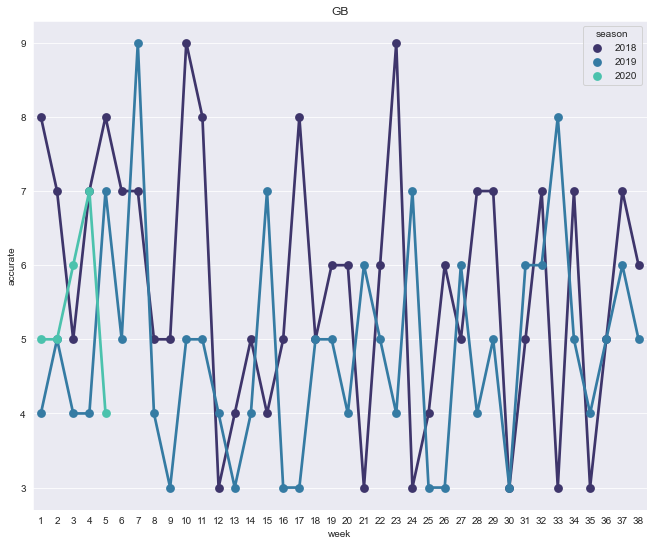

In [171]:
weeks_predictions(df)

Total wrong = 23/50
Error = 0.460


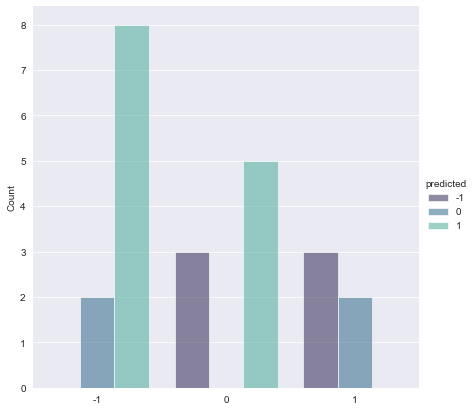

In [172]:
wrong_predictions(df, 2020)

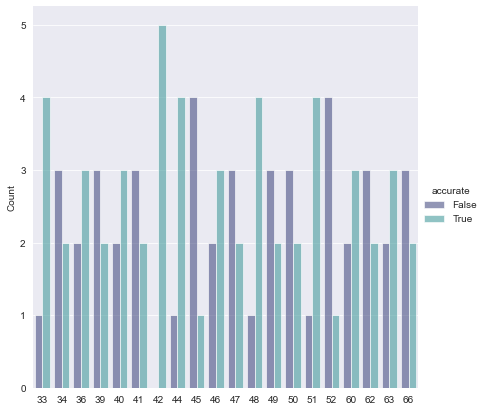

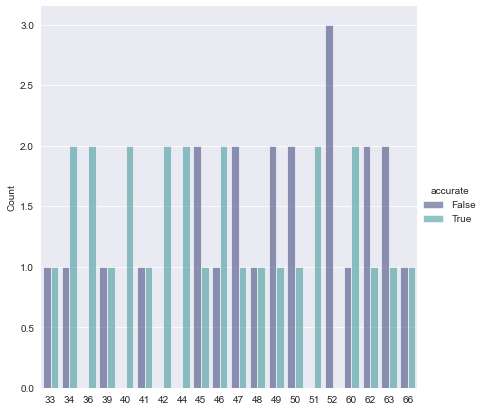

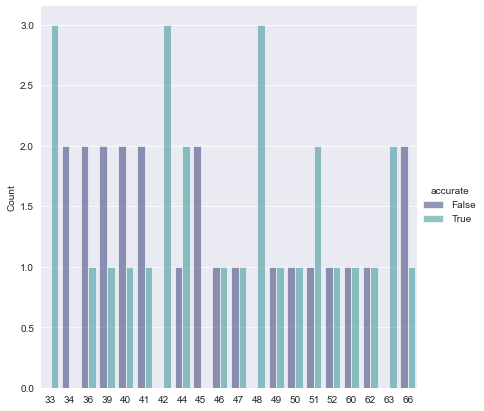

In [173]:
# When playing home or away
teams_predictions(df, 2020, "both")
# When playing home
teams_predictions(df, 2020, "home_team.id")
# When playing away
teams_predictions(df, 2020, "away_team.id")

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='0', clf_to_save='nb_ovo', if_anova='both', log_transform=True)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = custom_test(dct, '8', '3', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='1', clf_to_save='svc_ovo', if_anova=False)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [117]:
"""
    Everything to retrieve the data
"""
global country
country = 'FR'
league = '61'
curr_week = 7
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

0-3
hola
0-4
hola
1-3
hola
1-2
hola
0-2
hola
0-2
hola
0-3
hola
0-3
hola
2-3
hola
0-1
hola
0-2
hola
0-3
hola
0-1
hola
0-4
hola
0-3
0-1
0-4
0-3
2-3
2-3
2-3
0-1
0-2
0-2
1-3
0-3
1-2
1-3
0-4
0-2
1-0
hola
4-0
hola
2-1
hola
2-0
hola
4-1
hola
3-1
hola
3-2
hola
2-0
hola
3-2
hola
3-1
hola
4-0
hola
3-1
hola
3-1
hola
3-2
hola
2-1
hola
6-1
hola
4-1
hola
3-0
hola
0-3
0-1
0-4
0-3
2-3
2-3
2-3
0-1
0-2
0-2
1-3
0-3
1-2
1-3
0-4
0-2
0-3
hola
0-4
hola
1-3
hola
1-2
hola
0-2
hola
0-2
hola
0-3
hola
0-3
hola
2-3
hola
0-1
hola
0-2
hola
0-3
hola
0-1
hola
0-4
hola
0-3
0-1
0-4
0-3
2-3
2-3
2-3
0-1
0-2
0-2
1-3
0-3
1-2
1-3
0-4
0-2
1-0
hola
4-0
hola
2-1
hola
2-0
hola
4-1
hola
3-1
hola
3-2
hola
2-0
hola
3-2
hola
3-1
hola
4-0
hola
3-1
hola
3-1
hola
3-2
hola
2-1
hola
6-1
hola
4-1
hola
3-0
hola
0-3
0-1
0-4
0-3
2-3
2-3
2-3
0-1
0-2
0-2
1-3
0-3
1-2
1-3
0-4
0-2
0-3
hola
0-4
hola
1-3
hola
1-2
hola
0-2
hola
0-2
hola
0-3
hola
0-3
hola
2-3
hola
0-1
hola
0-2
hola
0-3
hola
0-1
hola
0-4
hola
1-0
hola
4-0
hola
2-1
hola
2-0
hola
4-1
ho

In [118]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 8
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, classifiers=["nb_ovo", "rforest_p", "rforest"], year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
10
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1  1]
 [ 0 -1 -1]
 [-1 -1 -1]
 [-1  0 -1]
 [ 0 -1  1]
 [ 1  1  1]
 [-1  0  1]
 [ 0 -1  1]]
[1, 1, -1, -1, -1, -1, 0, 1, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
20
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  0  1]
 [ 1  0  1]
 [ 0  0  0]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 1  1  0]
 [-1 -1 -1]]
[1, 1, -1, 1, 1, 0, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
30
[[-1 -1  0]
 [ 1  1  1]
 [ 1 -1  1]
 [-1  0 -1]
 [ 0  0  1]
 [ 1  1  1]
 [ 0  1  0]
 [ 1  1  1]
 [ 0 -1  1]
 [-1 -1 -1]]
[-1, 1, 1, -1, 0, 1, 0, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
40
[[ 0  1 -1]
 [-1 -1 -1]
 [ 0  0 -1]
 [ 0  1  1]
 [ 1 -1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0  1  0]
 [-1 -1  0]]
[0, -1, 0, 1, 1, 1, -1, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
50
[[ 1 -1  1]
 [-1 -1  0]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  0 -1]
 [ 1  1  0]
 [ 1 -1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0  0 -1]]
[1, -1, 1, -1, -1, 1, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
59
[[ 1  1  1]
 [ 0  0 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0  1  0]
 [ 0  1 -1]
 [ 1  1  0]
 [ 0  0 -1]]
[1, 0, -1, -1, 1, 0, 0, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
69
[[ 1  1  1]
 [-1 -1 -1]
 [ 0  0  1]
 [ 1  1  1]
 [-1  0  0]
 [ 1 -1  1]
 [ 0 -1  1]
 [ 0  1 -1]
 [ 1  1  1]
 [ 0 -1 -1]]
[1, -1, 0, 1, 0, 1, 0, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
79
[[ 1  1  1]
 [ 0  1  1]
 [ 1  0  0]
 [ 1  1  1]
 [ 0  1  0]
 [-1  0  1]
 [-1 -1 -1]
 [ 0  0  0]
 [-1 -1 -1]
 [ 0  1 -1]]
[1, 1, 0, 1, 0, 0, -1, 0, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
89
[[ 1  1  1]
 [-1  1  1]
 [ 1  1  1]
 [ 1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 1  0 -1]
 [ 1  0  1]
 [-1  0 -1]
 [ 1  1 -1]]
[1, 1, 1, -1, -1, -1, 0, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
99
[[-1  0 -1]
 [ 0 -1  1]
 [-1 -1  1]
 [ 1  1  1]
 [ 0  1  1]
 [ 1  0  1]
 [ 1  1  0]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]]
[-1, 0, -1, 1, 1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
109
[[ 1  0  1]
 [ 1  0  1]
 [-1  1  0]
 [-1  0 -1]
 [ 1  1  1]
 [ 1  0 -1]
 [ 0  0  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1 -1]]
[1, 1, 0, -1, 1, 0, 0, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
119
[[ 1 -1  1]
 [-1 -1 -1]
 [-1 -1  1]
 [ 1  1  1]
 [ 0 -1  1]
 [ 1 -1  1]
 [ 1  1  1]
 [ 1  1  0]
 [ 1  0  1]
 [-1  0 -1]]
[1, -1, -1, 1, 0, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
129
[[ 1  0  1]
 [ 1  1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  0]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  0  1]
 [-1  0 -1]
 [ 1 -1  0]]
[1, 1, 1, -1, 1, 1, -1, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
139
[[ 1  0 -1]
 [ 1  1  0]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]]
[0, 1, 1, -1, 1, -1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
149
[[ 1  1  1]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  0  1]
 [ 1  1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 1 -1  1]
 [-1 -1 -1]]
[1, 1, 1, 1, 1, 1, -1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
159
[[-1 -1 -1]
 [ 1  0  1]
 [ 1  1  1]
 [-1  0 -1]
 [ 1  1  1]
 [-1  0  0]
 [-1  1 -1]
 [ 1 -1  0]
 [ 1  1 -1]
 [ 1 -1  1]]
[-1, 1, 1, -1, 1, 0, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
169
[[ 1 -1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [ 1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 0  1  0]
 [ 1  1 -1]
 [ 1  1  1]
 [ 1  1  1]]
[1, 1, 1, -1, -1, -1, 0, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
179
[[ 1  0  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 0 -1  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  0  1]
 [ 0  0  1]
 [ 1  1 -1]
 [ 1 -1  1]]
[1, 1, -1, 0, 1, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
189
[[ 1 -1  1]
 [ 1 -1  1]
 [ 1 -1 -1]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]]
[1, 1, -1, 1, 1, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
199
[[ 1  0  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1 -1]
 [-1 -1  0]
 [ 1 -1  1]
 [ 0  0  1]
 [ 1  1  1]
 [ 1  1  1]]
[1, 1, -1, 1, 1, -1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
209
[[ 1  1  1]
 [-1 -1 -1]
 [ 1 -1 -1]
 [-1 -1 -1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  1  0]
 [ 1  1  0]
 [ 1  1  1]
 [ 1  1 -1]]
[1, -1, -1, -1, 1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
219
[[ 1  1  1]
 [-1 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1 -1  1]
 [ 0 -1  0]
 [ 1  1  1]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  0  0]]
[1, -1, -1, 1, 1, 0, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
229
[[ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 0  1  0]
 [ 1 -1  1]
 [ 1  0  1]
 [ 0  0 -1]
 [ 0  1  1]
 [ 0  1  0]]
[1, -1, 1, -1, 0, 1, 1, 0, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
239
[[ 1 -1  1]
 [ 1 -1  1]
 [-1 -1  1]
 [ 1 -1  0]
 [ 1 -1  0]
 [ 0 -1  0]
 [ 1  1  0]
 [-1 -1 -1]
 [ 1  1  1]
 [-1  1 -1]]
[1, 1, -1, 0, 0, 0, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
249
[[ 1  1  1]
 [ 0 -1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0 -1  1]
 [ 1  0  1]
 [-1 -1 -1]
 [ 0  1 -1]
 [-1 -1  0]
 [ 1 -1  0]]
[1, 0, 1, 1, 0, 1, -1, 0, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
259
[[ 1 -1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [-1  0  0]
 [-1 -1 -1]
 [ 1 -1  1]
 [ 0  0  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  0]]
[1, -1, 1, 0, -1, 1, 0, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
269
[[ 1  0  1]
 [ 1  1  0]
 [ 1  1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 0  1  0]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [ 0  0 -1]]
[1, 1, 1, 1, -1, 0, 1, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
279
[[-1 -1  1]
 [ 1  1  1]
 [ 1 -1  1]
 [-1  0  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  0 -1]
 [ 1  1  0]]
[-1, 1, 1, 0, 1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
289
[[ 1  0  1]
 [ 0  1 -1]
 [ 1  1  1]
 [ 0 -1  1]
 [ 0  1  1]
 [-1  0 -1]
 [ 1  1  0]
 [ 1 -1  1]
 [-1  1  1]
 [ 1 -1  0]]
[1, 0, 1, 0, 1, -1, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
299
[[ 1 -1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [-1  1  0]
 [ 1  1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0  1 -1]
 [ 1  1  1]]
[1, -1, 1, 0, 1, 1, -1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
309
[[ 1  0  1]
 [-1 -1  0]
 [ 0 -1  0]
 [ 1  1  1]
 [ 1  1 -1]
 [-1  0 -1]
 [ 1 -1  0]
 [ 1  0 -1]
 [ 1  1  1]
 [-1 -1 -1]]
[1, -1, 0, 1, 1, -1, 0, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
319
[[ 1  1  1]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0 -1  0]
 [ 1 -1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  0 -1]
 [ 1  1  0]]
[1, -1, 1, 1, 0, 1, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
329
[[ 0  0 -1]
 [ 1  1  1]
 [ 0 -1 -1]
 [ 1 -1  1]
 [ 1  1  1]
 [ 0 -1 -1]
 [-1 -1 -1]
 [ 1  1  0]
 [ 1 -1  1]
 [ 1  1  1]]
[0, 1, -1, 1, 1, -1, -1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
339
[[ 1 -1 -1]
 [ 0 -1  1]
 [ 1  1  1]
 [ 0  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [ 1 -1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1 -1 -1]]
[-1, 0, 1, 1, 1, 1, 1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
349
[[-1 -1 -1]
 [-1  0  0]
 [ 1  0  1]
 [ 1 -1  1]
 [ 1 -1  1]
 [ 0 -1  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0 -1  1]]
[-1, 0, 1, 1, 1, 0, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
359
[[ 1  0  1]
 [ 1  1  1]
 [ 1 -1  1]
 [ 0 -1  0]
 [-1 -1  1]
 [ 0 -1  0]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]]
[1, 1, 1, 0, -1, 0, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
369
[[ 1 -1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  0  1]
 [-1  1 -1]
 [ 0  0  0]
 [ 1  1  1]
 [ 0  1  0]
 [ 0 -1  1]]
[1, 1, 1, -1, 0, -1, 0, 1, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
379
[[-1 -1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [ 1  0  1]
 [ 0  1  0]
 [ 1  1  1]
 [ 0  1  1]
 [ 1  1  1]
 [ 1 -1  1]
 [ 1  0 -1]]
[-1, -1, 1, 1, 0, 1, 1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
389
[[ 1 -1  1]
 [-1 -1  1]
 [ 1  1 -1]
 [-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]
 [ 0  0  1]
 [ 1 -1  0]
 [ 1  1  1]
 [ 1  1  1]]
[1, -1, 1, -1, 0, 1, 0, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
399
[[ 1 -1  1]
 [ 0 -1  0]
 [-1 -1 -1]
 [-1  0  0]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  1  0]
 [-1  0 -1]
 [ 1  0 -1]
 [ 1  1  1]]
[1, 0, -1, 0, 1, 1, 1, -1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
409
[[ 1 -1  1]
 [ 1 -1  1]
 [ 0  0  0]
 [ 1 -1  1]
 [ 1 -1  1]
 [ 1  1  1]
 [ 1  0  1]
 [-1  0 -1]
 [ 1  1  1]
 [-1 -1 -1]]
[1, 1, 0, 1, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
419
[[-1 -1  1]
 [ 1  0  1]
 [-1 -1  0]
 [ 1  1  1]
 [ 1 -1  1]
 [ 1  0  1]
 [ 1 -1  0]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  0]]
[-1, 1, -1, 1, 1, 1, 0, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
429
[[-1  0  1]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  0  0]
 [ 1  1  1]
 [ 1 -1  1]
 [ 1  1  1]
 [ 1  0 -1]
 [ 1  0  1]]
[0, -1, -1, 1, 0, 1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
439
[[ 1  0  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  0  1]
 [-1 -1  1]
 [ 1  1  0]
 [ 1 -1  1]
 [-1 -1  0]
 [ 1  1  1]
 [ 1  0  1]]
[1, 1, -1, 1, -1, 1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
449
[[-1  0 -1]
 [ 0 -1  0]
 [ 1  0  1]
 [ 1  1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1 -1  1]
 [ 1  1  1]
 [ 1  0  1]]
[-1, 0, 1, 1, 1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
459
[[ 1  1  1]
 [ 1 -1  1]
 [ 0  1  1]
 [ 1 -1  1]
 [ 1  0  1]
 [ 1  1  1]
 [ 0  1  0]
 [ 1 -1  0]
 [-1  0 -1]
 [-1 -1 -1]]
[1, 1, 1, 1, 1, 1, 0, 0, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
469
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1  0]
 [ 1 -1  0]
 [-1 -1 -1]
 [ 1  0  0]
 [ 1  1  1]
 [ 1 -1  1]
 [ 1  1  1]
 [-1  1 -1]]
[1, 1, -1, 0, -1, 0, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
479
[[ 1 -1  1]
 [-1  1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 0 -1  1]
 [ 1  0  0]
 [-1 -1 -1]
 [ 1 -1  0]]
[1, -1, 1, 1, 1, -1, 0, 0, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
489
[[ 1 -1  1]
 [-1 -1  0]
 [ 1  1  0]
 [ 1 -1  1]
 [ 1 -1  1]
 [ 0  1  1]
 [ 1  0  0]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]]
[1, -1, 1, 1, 1, 1, 0, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
499
[[ 1  0  1]
 [-1 -1 -1]
 [ 0  1  0]
 [ 1  0  1]
 [-1 -1 -1]
 [ 1  0  1]
 [ 0  1  1]
 [ 1  1  0]
 [ 1  1  1]
 [ 1  1  1]]
[1, -1, 0, 1, -1, 1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
509
[[ 1 -1  1]
 [-1  1  0]
 [ 1  0  1]
 [-1 -1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  0  1]
 [ 1 -1  1]
 [ 1  1  1]
 [ 1  1  1]]
[1, 0, 1, -1, 1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
519
[[ 1  1  1]
 [ 0 -1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  0  0]
 [ 1 -1  1]
 [-1 -1  0]
 [ 1  1  1]
 [-1  0 -1]]
[1, 0, 1, -1, 1, 0, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
529
[[-1 -1  1]
 [ 1 -1  1]
 [-1 -1  0]
 [-1  1 -1]
 [ 1  0  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  0  1]]
[-1, 1, -1, -1, 1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
539
[[ 1  1  1]
 [ 0 -1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1 -1 -1]
 [ 1  1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0  0 -1]]
[1, 0, 1, -1, -1, 1, 1, -1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
549
[[ 1  1  1]
 [-1 -1 -1]
 [-1 -1  0]
 [ 1  1  1]
 [ 1  0  1]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  0  1]
 [-1 -1 -1]]
[1, -1, -1, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
559
[[ 1  0  1]
 [ 0  1  0]
 [ 1  1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1  0  0]
 [ 1  1 -1]
 [-1 -1  1]
 [-1  0 -1]
 [ 1  1  1]]
[1, 0, 1, 1, -1, 0, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
569
[[-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  0  1]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]]
[-1, -1, 1, 1, -1, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
579
[[ 1 -1  1]
 [-1  1  0]
 [ 1  0  1]
 [-1  1  0]
 [ 1  1  1]
 [ 1 -1  1]
 [ 0 -1  1]
 [ 1  0 -1]
 [ 1  1  1]
 [-1 -1 -1]]
[1, 0, 1, 0, 1, 1, 0, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
589
[[-1 -1 -1]
 [ 1  1  1]
 [ 1  1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [-1 -1 -1]
 [ 1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]]
[-1, 1, 1, 1, -1, 1, -1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
599
[[ 1 -1 -1]
 [-1  0 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0  1  0]
 [-1 -1  1]
 [ 1  0  1]
 [-1  0 -1]
 [ 1  1  1]
 [-1 -1 -1]]
[-1, -1, 1, 1, 0, -1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
609
[[ 1  1  1]
 [-1 -1 -1]
 [ 1  0  1]
 [ 1  1  1]
 [ 0  1  1]
 [-1 -1  1]
 [ 0 -1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]]
[1, -1, 1, 1, 1, -1, 0, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
619
[[ 1 -1  1]
 [ 1  1  0]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0 -1  1]
 [-1 -1 -1]
 [-1  1  1]
 [-1  1 -1]
 [ 1  0 -1]]
[1, 1, 1, -1, 1, 0, -1, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
629
[[ 1  1  1]
 [ 0  0  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1 -1  0]
 [ 0 -1  0]
 [ 1 -1  1]
 [ 1 -1  1]
 [ 1  1  1]]
[1, 0, -1, 1, 1, 0, 0, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
639
[[ 1 -1  1]
 [-1  1  0]
 [-1  0 -1]
 [ 1  0  0]
 [ 1 -1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  1  0]
 [ 0  1  0]
 [ 1  1  1]]
[1, 0, -1, 0, 1, 1, -1, 0, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
649
[[-1 -1 -1]
 [-1 -1  0]
 [ 1 -1  1]
 [ 1  0  1]
 [ 0 -1  0]
 [ 0  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0  0 -1]]
[-1, -1, 1, 1, 0, 1, -1, 1, 1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
658
[[-1  0  0]
 [ 1  1 -1]
 [ 1  1  1]
 [ 1 -1  1]
 [ 1 -1  1]
 [-1 -1 -1]
 [-1 -1  0]
 [ 1  0  1]
 [-1 -1  1]]
[0, 1, 1, 1, 1, -1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
668
[[ 0 -1  1]
 [ 0  0  0]
 [ 0 -1 -1]
 [ 1  1  1]
 [-1  1  0]
 [ 1  1  1]
 [ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]]
[0, 0, -1, 1, 0, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only medi

Total accurate = 342/728
Accuracy = 0.470


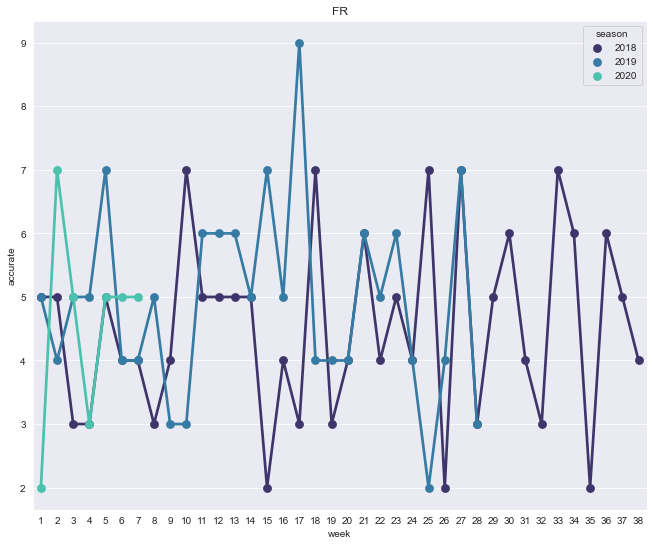

In [119]:
weeks_predictions(df)

Total wrong = 38/70
Error = 0.543


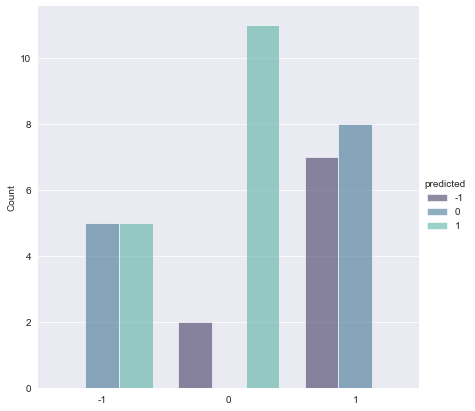

In [120]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 8
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='0', clf_to_save='nb_ovo', if_anova='both', log_transform=True)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 8
accuracy, df = custom_test(dct, '8', '3', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='1', clf_to_save='svc_ovo', if_anova=False)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [174]:
"""
    Everything to retrieve the data
"""
global country
country = 'NL'
league = '88'
curr_week = 6
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

1-4
hola
0-3
hola
0-13
hola
1-3
hola
1-3
hola
0-2
hola
0-1
hola
0-1
hola
0-1
hola
3-5
hola
0-13
1-3
0-3
3-5
1-3
1-2
0-3
0-1
1-4
0-2
4-0
hola
5-1
hola
4-0
hola
4-0
hola
3-1
hola
1-0
hola
2-0
hola
4-2
hola
3-0
hola
3-1
hola
2-0
hola
0-13
1-3
0-3
3-5
1-3
1-2
0-3
0-1
1-4
0-2
1-4
hola
0-3
hola
0-13
hola
1-3
hola
1-3
hola
0-2
hola
0-1
hola
0-1
hola
0-1
hola
3-5
hola
0-13
1-3
0-3
3-5
1-3
1-2
0-3
0-1
1-4
0-2
4-0
hola
5-1
hola
4-0
hola
4-0
hola
3-1
hola
1-0
hola
2-0
hola
4-2
hola
3-0
hola
3-1
hola
2-0
hola
0-13
1-3
0-3
3-5
1-3
1-2
0-3
0-1
1-4
0-2
1-4
hola
0-3
hola
0-13
hola
1-3
hola
1-3
hola
0-2
hola
0-1
hola
0-1
hola
0-1
hola
3-5
hola
4-0
hola
5-1
hola
4-0
hola
4-0
hola
3-1
hola
1-0
hola
2-0
hola
4-2
hola
3-0
hola
3-1
hola
2-0
hola
0-13
hola
1-3
hola
0-3
hola
3-5
hola
1-3
hola
1-2
hola
0-3
hola
0-1
hola
1-4
hola
0-2
hola
0-13
hola
1-3
hola
0-3
hola
3-5
hola
1-3
hola
1-2
hola
0-3
hola
0-1
hola
1-4
hola
0-2
hola
0-2
hola
0-2
hola
0-4
hola
1-3
hola
2-5
hola
0-4
hola
1-3
hola
1-3
hola
0-3
hola
0-4

In [175]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 7
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, classifiers=["nb_ovo", "rforest_p", "rforest"], year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
9


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
18


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
27


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
36


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
45


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
54


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
63


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
72


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
81


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
90


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
99


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
108


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
117


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
126


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
135


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
144


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
153


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
162


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
171


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
180


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
189


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
198


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
207


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
216


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
225


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
234


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
243


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
252


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
261


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
270


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
279


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
288


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
297


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
306


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
315


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
324


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
333


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
342


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
351


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
360


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
369


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
378


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
387


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
396


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
405


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
414


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
423


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
432


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
441


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
450


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
459


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
468


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
477


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
486


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
495


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
502


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
511


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
520


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
529


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
538


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
546


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
555


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
564


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
573


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
582


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
591


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


{'rforest_p': {'score': 0.5245346869712352, 'predicted': [[11, 65, 51], [18, 201, 75], [12, 60, 98]]}, 'nb_ovo': {'score': 0.5279187817258884, 'predicted': [[41, 32, 54], [73, 164, 57], [25, 38, 107]]}, 'svc_ovo_p': {'score': 0.4890016920473773, 'predicted': [[21, 55, 51], [53, 167, 74], [31, 38, 101]]}, 'rforest': {'score': 0.5516074450084603, 'predicted': [[24, 60, 43], [35, 212, 47], [27, 53, 90]]}, 'vote': {'score': 0.5583756345177665, 'predicted': [[30, 48, 49], [47, 198, 49], [24, 44, 102]]}}


Total accurate = 330/591
Accuracy = 0.558


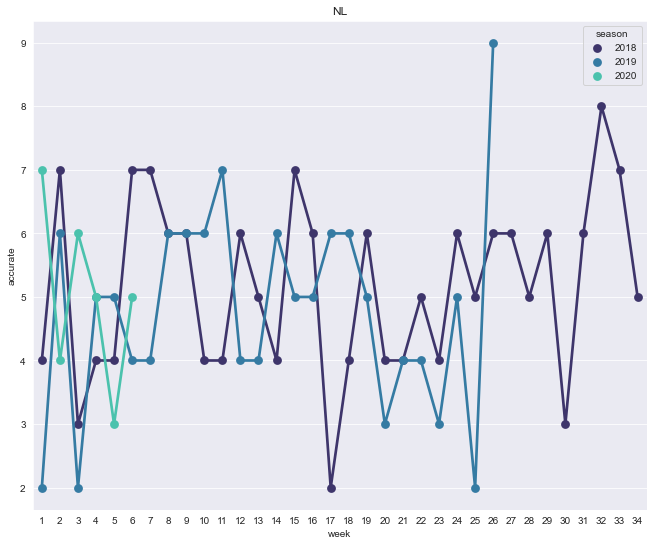

In [176]:
weeks_predictions(df)

Total wrong = 23/53
Error = 0.434


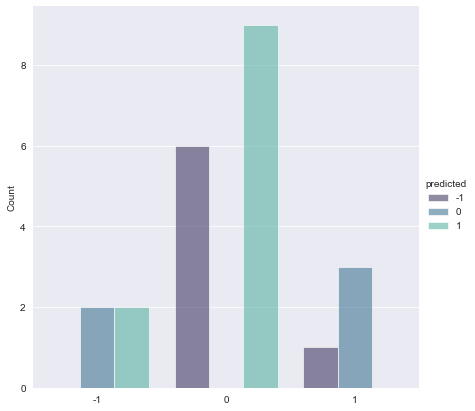

In [177]:
wrong_predictions(df, 2020)

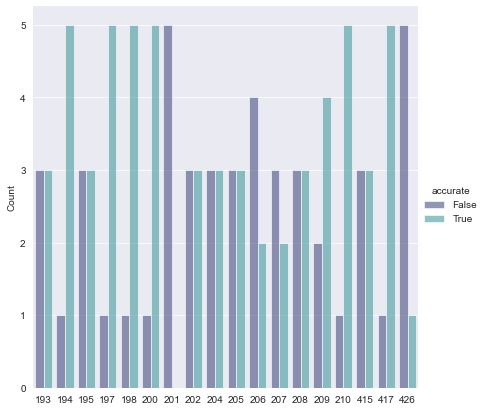

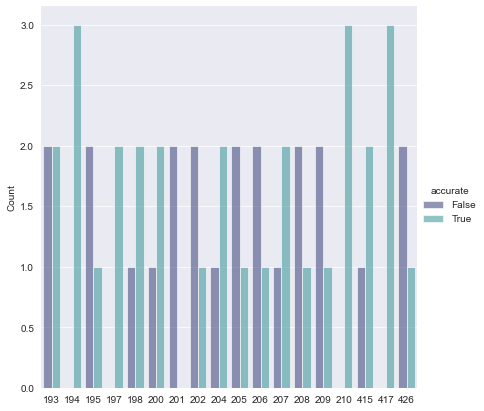

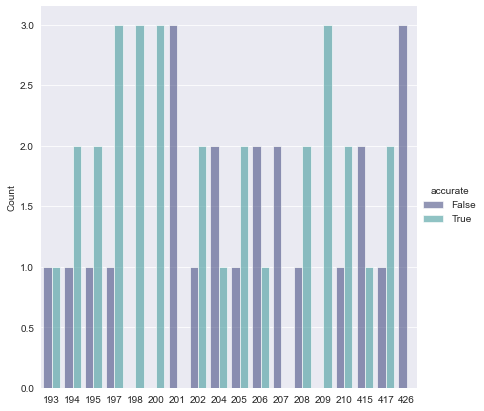

In [178]:
# When playing home or away
teams_predictions(df, 2020, "both")
# When playing home
teams_predictions(df, 2020, "home_team.id")
# When playing away
teams_predictions(df, 2020, "away_team.id")

In [179]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 7
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='0', clf_to_save='rforest', if_anova='both', log_transform=True)
print(accuracy)

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
9


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
18


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
27


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
36


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
45


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
54


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
63


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
72


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
81


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
90


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
99


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
108


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
117


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
126


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
135


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
144


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
153


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
162


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
171


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
180


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
189


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
198


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
207


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
216


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
225


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
234


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
243


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
252


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
261


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
270


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
279


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
288


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
297


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
306


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
315


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
324


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
333


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
342


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
351


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
360


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
369


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
378


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
387


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
396


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
405


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
414


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
423


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
432


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
441


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
450


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
459


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
468


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
477


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
486


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
495


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
502


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
511


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
520


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
529


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
538


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
546


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
555


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
564


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
573


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
582


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons


Plain train set with clusters
Test Method
Current and past season median


Plain test set with clusters
591


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

{'rforest': {'score': 0.5516074450084603, 'predicted': [[24, 60, 43], [35, 212, 47], [27, 53, 90]]}, 'nb_ovo': {'score': 0.5279187817258884, 'predicted': [[41, 32, 54], [73, 164, 57], [25, 38, 107]]}, 'svc_ovo': {'score': 0.5211505922165821, 'predicted': [[22, 52, 53], [43, 196, 55], [17, 63, 90]]}, 'ridge': {'score': 0.4805414551607445, 'predicted': [[44, 37, 46], [89, 157, 48], [41, 46, 83]]}}


Total accurate = 326/591
Accuracy = 0.552


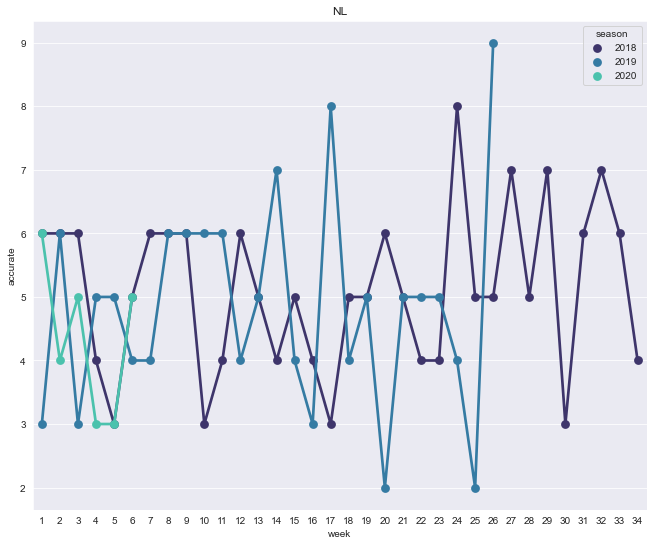

In [180]:
weeks_predictions(df)

Total wrong = 27/53
Error = 0.509


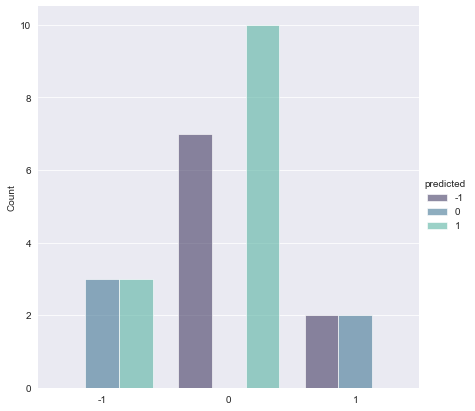

In [181]:
wrong_predictions(df, 2020)

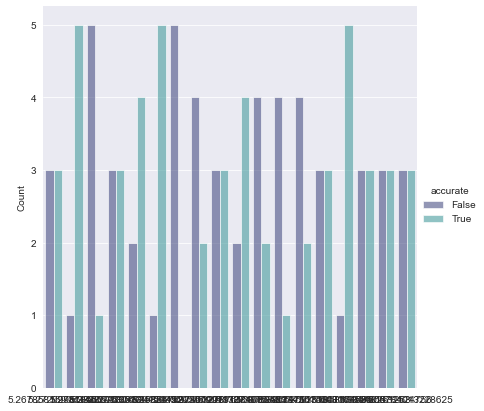

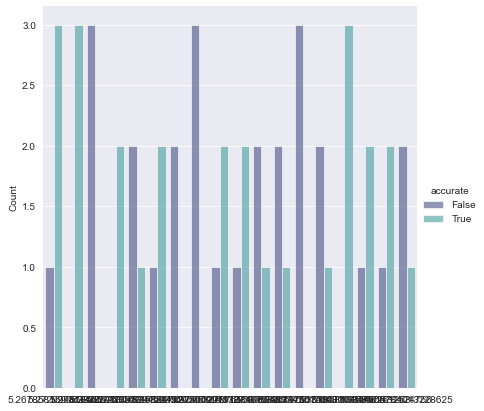

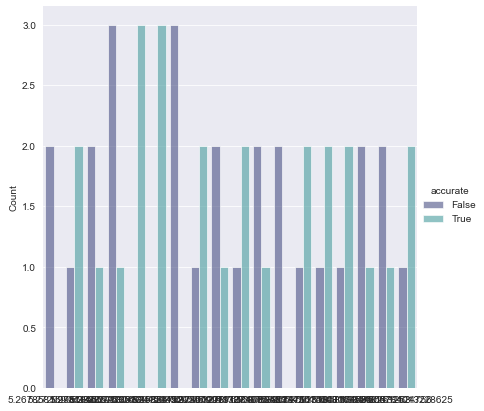

In [182]:
# When playing home or away
teams_predictions(df, 2020, "both")
# When playing home
teams_predictions(df, 2020, "home_team.id")
# When playing away
teams_predictions(df, 2020, "away_team.id")

In [ ]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 7
accuracy, df = custom_test(dct, '8', '3', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='1', clf_to_save='svc_ovo', if_anova=False)
print(accuracy)

In [ ]:
weeks_predictions(df)

In [ ]:
wrong_predictions(df, 2020)

In [125]:
"""
    Everything to retrieve the data
"""
global country
country = 'PT'
league = '94'
curr_week = 5
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

0-2
hola
1-2
hola
0-4
hola
1-5
hola
1-2
hola
0-3
hola
0-1
hola
0-2
hola
2-3
hola
0-1
hola
0-5
hola
1-2
hola
0-1
hola
1-2
1-5
0-1
1-2
0-1
0-1
0-4
0-2
0-5
0-1
0-1
2-3
1-0
hola
2-0
hola
2-0
hola
1-0
hola
2-1
hola
2-1
hola
3-1
hola
2-0
hola
1-0
hola
2-1
hola
1-2
1-5
0-1
1-2
0-1
0-1
0-4
0-2
0-5
0-1
0-1
2-3
0-2
hola
1-2
hola
0-4
hola
1-5
hola
1-2
hola
0-3
hola
0-1
hola
0-2
hola
2-3
hola
0-1
hola
0-5
hola
1-2
hola
0-1
hola
1-2
1-5
0-1
1-2
0-1
0-1
0-4
0-2
0-5
0-1
0-1
2-3
1-0
hola
2-0
hola
2-0
hola
1-0
hola
2-1
hola
2-1
hola
3-1
hola
2-0
hola
1-0
hola
2-1
hola
1-2
1-5
0-1
1-2
0-1
0-1
0-4
0-2
0-5
0-1
0-1
2-3
0-2
hola
1-2
hola
0-4
hola
1-5
hola
1-2
hola
0-3
hola
0-1
hola
0-2
hola
2-3
hola
0-1
hola
0-5
hola
1-2
hola
0-1
hola
1-0
hola
2-0
hola
2-0
hola
1-0
hola
2-1
hola
2-1
hola
3-1
hola
2-0
hola
1-0
hola
2-1
hola
1-2
hola
1-5
hola
0-1
hola
1-2
hola
0-1
hola
0-1
hola
0-4
hola
0-2
hola
0-5
hola
0-1
hola
0-1
hola
2-3
hola
1-2
hola
1-5
hola
0-1
hola
1-2
hola
0-1
hola
0-1
hola
0-4
hola
0-2
hola
0-5
hol

In [129]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, classifiers=["nb_ovo", "rforest_p", "svc_ovo_p"], year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
9


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1  1  1]
 [ 0  1  1]
 [-1  1  0]
 [ 1  1  1]
 [ 1 -1  0]
 [-1 -1 -1]
 [ 0  1  0]
 [ 1 -1 -1]]
[1, 1, 1, 0, 1, 0, -1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
18


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0  1  0]
 [ 1  1  1]
 [ 0 -1 -1]
 [-1  0  0]]
[-1, 1, -1, 1, 1, 0, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
27


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  0  1]
 [ 1  1  0]
 [ 1 -1 -1]
 [-1  0 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0 -1 -1]
 [ 1  1  1]]
[1, 1, -1, -1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
36


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 0 -1 -1]
 [ 1  1  1]
 [ 1 -1 -1]
 [-1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1  0]
 [ 1  1  1]
 [-1 -1 -1]]
[-1, 1, -1, 1, 1, 1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
45


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1 -1 -1]
 [ 1  1  1]
 [ 1  0 -1]
 [ 1  0  1]
 [-1 -1  0]
 [ 1  1  0]
 [ 1 -1 -1]
 [ 0  1  1]
 [-1  1  1]]
[-1, 1, 0, 1, -1, 1, -1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
54


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1  0]
 [-1  1  0]
 [ 1  1  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  0]
 [ 0 -1 -1]]
[-1, 0, 1, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
63


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [-1  1  1]
 [ 1  0 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  0 -1]
 [ 0 -1 -1]
 [ 1  1  1]]
[-1, 1, 0, -1, 1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
72


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 0 -1 -1]
 [ 1  0  0]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1  1]
 [-1 -1 -1]]
[-1, 0, -1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
81


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  0  1]
 [ 1  1  0]
 [ 1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]]
[1, 1, -1, 1, 1, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
90


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 1 -1 -1]
 [ 1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1  0]
 [ 1  1  1]
 [ 1  1  0]]
[-1, -1, -1, 1, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
99


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1  0]
 [ 1  1  1]
 [ 0  1  1]
 [-1 -1 -1]
 [-1  1  0]
 [ 1  1  1]
 [ 0  0 -1]
 [-1 -1 -1]
 [ 0 -1 -1]]
[1, 1, 1, -1, 0, 1, 0, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
108


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1  1 -1]
 [ 1  0 -1]
 [-1 -1  0]
 [ 1  1  1]
 [ 1  1  0]
 [ 0  1  0]
 [ 1  1  1]
 [ 0 -1 -1]
 [ 1  1  1]]
[-1, 0, -1, 1, 1, 0, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
117


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1 -1]
 [-1 -1 -1]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0  1  1]
 [ 0  0  1]
 [-1 -1 -1]]
[1, -1, -1, 1, 1, 1, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
126


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1  1  1]
 [ 1  0 -1]
 [ 0  0  1]
 [ 1  1  0]
 [ 1  0 -1]
 [-1  0 -1]
 [ 0 -1 -1]
 [-1  1  0]]
[1, 1, 0, 0, 1, 0, -1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
135


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 0  1  0]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 0 -1 -1]
 [ 0 -1 -1]]
[-1, 0, -1, 1, 1, 1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
144


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [-1 -1 -1]
 [ 1  0 -1]
 [ 1 -1 -1]
 [ 1  1  1]
 [ 1  1 -1]
 [-1 -1 -1]
 [-1 -1  1]
 [ 0  1  1]]
[1, -1, 0, -1, 1, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
153


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  0]
 [ 1  1  1]
 [ 0  1  1]
 [ 1  1  1]
 [ 0  1 -1]
 [ 1  1  1]]
[1, -1, 1, 1, 1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
162


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1  1 -1]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1 -1  0]
 [-1 -1 -1]
 [-1  0 -1]]
[1, 1, 1, 1, 1, -1, -1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
171


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  0]
 [-1 -1 -1]
 [ 0 -1 -1]
 [ 0  1  0]]
[-1, 1, -1, -1, 1, 1, -1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
180


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1  0 -1]
 [-1 -1 -1]
 [ 1  0 -1]
 [ 1  1  1]
 [ 1  0  0]
 [ 1  1  1]
 [-1 -1  1]
 [ 0  1 -1]
 [ 1  1  1]]
[-1, -1, 0, 1, 0, 1, -1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
189


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1 -1 -1]
 [ 1  1  1]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1  1  0]
 [-1  0 -1]]
[-1, 1, -1, 1, 1, -1, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
198


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  0]
 [ 0  1  0]
 [ 0 -1 -1]
 [-1  0  1]
 [ 1 -1  0]]
[-1, 1, 1, 1, 1, 0, -1, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
207


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1 -1 -1]
 [ 1  1  1]
 [-1  1  0]
 [-1 -1 -1]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 1 -1 -1]
 [-1  0 -1]
 [ 0  1  1]]
[-1, 1, 0, -1, -1, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
216


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1 -1 -1]
 [ 1  1  1]
 [-1  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [ 0 -1 -1]
 [ 0  0  0]
 [ 1  1  1]
 [ 0 -1 -1]]
[-1, 1, 1, 1, 1, -1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
225


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1 -1 -1]
 [ 1  1  1]
 [ 0  1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [-1 -1 -1]
 [ 0  1  1]
 [-1 -1 -1]]
[-1, 1, 0, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
234


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1  0 -1]
 [-1  1  0]
 [-1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0 -1 -1]]
[1, 0, 0, 1, 1, 1, -1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
243


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  0 -1]
 [ 1  1  1]
 [ 0 -1 -1]
 [ 1  1  1]
 [-1  1  1]
 [-1 -1 -1]
 [ 1  0  0]
 [-1  1  0]
 [ 0 -1 -1]]
[0, 1, -1, 1, 1, -1, 0, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
252


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1  1  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [-1 -1  0]
 [ 1  1  1]
 [-1 -1 -1]
 [-1 -1  0]]
[0, 1, 1, 1, 1, -1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
261


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 1  1  1]
 [ 0  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  0 -1]
 [ 0  1  1]]
[-1, 1, 1, -1, 1, 1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
270


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1  1]
 [ 1 -1 -1]
 [ 1 -1 -1]
 [-1  0  1]
 [ 1  1  0]
 [ 1  0 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  0  1]]
[1, -1, -1, 0, 1, 0, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
279


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 0 -1 -1]
 [ 1 -1 -1]
 [-1  1  1]
 [-1  0  0]
 [ 1  1  1]
 [-1  1  0]
 [ 0  1  1]
 [ 0  1  1]]
[1, -1, -1, 1, 0, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
288


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1 -1  0]
 [-1 -1 -1]
 [ 1  1 -1]
 [ 1  1  0]
 [ 1 -1 -1]
 [-1  1  1]
 [-1 -1  1]
 [ 1  0  0]]
[1, 0, -1, 1, 1, -1, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
297


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1  1  1]
 [ 1  1  0]
 [-1  0  0]
 [ 1  1  1]
 [ 1  0 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  0 -1]]
[1, 1, 1, 0, 1, 0, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
306


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 0 -1 -1]
 [-1  0  0]
 [ 1  1 -1]
 [ 1  1  1]
 [ 1 -1 -1]
 [ 0 -1 -1]
 [ 0 -1 -1]
 [-1  1  1]]
[1, -1, 0, 1, 1, -1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
315


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  1  1]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 0  1  0]
 [-1  1  1]]
[-1, -1, 1, -1, 1, -1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
324


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1  1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  1  1]
 [ 0  0 -1]
 [ 1  1  0]
 [-1  1  1]
 [ 1 -1 -1]]
[-1, 1, 1, -1, 1, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
333


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1  1  0]
 [-1  1  0]
 [-1  1  1]
 [ 1  1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1 -1]
 [ 0  0  1]
 [ 1 -1 -1]]
[0, 0, 1, 1, 1, -1, -1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
342


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 0 -1 -1]
 [-1 -1 -1]
 [ 0  1 -1]
 [-1  0  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  0]
 [-1 -1 -1]]
[1, -1, -1, 0, 0, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
351


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1  1  1]
 [ 1  1  1]
 [ 1  0 -1]
 [ 1  1  1]
 [ 1  0 -1]
 [-1  1  1]
 [ 1  1  0]
 [-1 -1  0]
 [ 1 -1 -1]]
[1, 1, 0, 1, 0, 1, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
360


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  0 -1]
 [-1  1 -1]
 [ 0  1  0]
 [-1 -1  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  0]
 [ 1  1  0]
 [-1 -1 -1]]
[0, -1, 0, -1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
369


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 1  1  1]
 [ 1  0  1]
 [-1 -1 -1]
 [ 1  1  0]
 [-1 -1  0]
 [ 1  0  1]
 [ 0 -1  0]
 [-1 -1  0]]
[-1, 1, 1, -1, 1, -1, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
378


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1  0]
 [-1 -1 -1]
 [ 0  1  1]
 [ 0  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  0]
 [ 1 -1 -1]]
[-1, -1, 1, 1, 1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
387


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1  1]
 [ 1  1  1]
 [ 1 -1 -1]
 [ 1  1  1]
 [ 1  0 -1]
 [-1 -1  0]
 [ 1 -1 -1]
 [-1 -1  0]
 [-1 -1  1]]
[1, 1, -1, 1, 0, -1, -1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
396


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1  1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  1  0]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]
[1, 1, 1, -1, 0, -1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
405


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1 -1 -1]
 [ 0  0  0]
 [ 1  1  0]
 [-1 -1  1]
 [-1 -1  0]]
[-1, -1, 1, 1, -1, 0, 1, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
414


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1  0]
 [-1  0 -1]
 [ 1  1  1]
 [ 1  0 -1]
 [ 0 -1 -1]
 [-1  1  0]
 [ 1  1  1]
 [ 1  1  1]
 [ 0 -1 -1]]
[-1, -1, 1, 0, -1, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
423


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [ 1  1  1]
 [-1  1  1]
 [ 1  1  1]
 [ 1  1  0]
 [ 1  1  1]
 [ 1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]]
[-1, 1, 1, 1, 1, 1, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
432


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1  1  0]
 [ 1  1 -1]
 [ 1  1  1]
 [-1  0  0]
 [ 0  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [ 0 -1 -1]
 [ 0  1  0]]
[0, 1, 1, 0, 1, 1, 1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
441


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1  1  1]
 [ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  0]
 [ 1 -1  1]
 [-1  0  0]
 [ 1 -1 -1]
 [-1 -1  0]]
[1, -1, 1, -1, 1, 1, 0, -1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
450


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [-1  1  1]
 [ 1  1  1]
 [-1 -1  1]
 [-1  1  0]
 [-1  1  1]]
[-1, 1, 1, 1, 1, 1, -1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
459


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0  1  1]
 [ 1 -1 -1]
 [-1 -1 -1]
 [-1  0  1]
 [ 1  1  0]
 [ 1  1  1]]
[-1, -1, 1, 1, -1, -1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
468


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 0  1  1]
 [ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  0  1]]
[1, -1, 1, -1, 1, -1, 1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
477


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1 -1 -1]
 [ 1 -1 -1]
 [ 1  1  0]
 [ 1  0  0]
 [-1  1 -1]
 [-1  1  1]
 [-1  1  1]
 [-1  1  0]
 [ 1  1  1]]
[-1, -1, 1, 0, -1, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
486


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1  0]
 [ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1 -1  1]
 [ 0  0 -1]
 [ 1 -1 -1]
 [ 0  1  1]]
[1, -1, 1, -1, 1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
495


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1 -1 -1]
 [ 1  1  1]
 [ 1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  1  1]
 [-1  0  1]
 [ 0 -1 -1]
 [ 0  1  1]]
[-1, 1, -1, 1, -1, 1, 0, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
504


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1 -1 -1]
 [ 0 -1 -1]
 [-1 -1 -1]
 [ 0  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1  0]
 [ 1  1  0]
 [ 1  1 -1]]
[-1, -1, -1, 1, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
513


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1  1]
 [ 1  1  1]
 [-1 -1  0]
 [ 1 -1 -1]
 [-1  1  1]
 [ 1 -1 -1]
 [ 1 -1  0]
 [-1  1  1]
 [-1 -1 -1]]
[1, 1, -1, -1, 1, -1, 0, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
522


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  0 -1]
 [ 0 -1 -1]
 [-1  1  0]
 [-1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1  0]
 [ 1  1  1]
 [ 1  1  1]]
[0, -1, 0, -1, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
531


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1 -1]
 [-1  1  1]
 [ 1  0  0]
 [-1 -1  0]
 [-1  1 -1]
 [ 0  1  1]]
[1, 1, -1, -1, 1, 0, -1, -1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
540


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1 -1  0]
 [-1 -1 -1]
 [ 0 -1 -1]
 [-1  1  0]
 [-1 -1  0]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1 -1]]
[-1, -1, -1, 0, -1, 1, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
549


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  0 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0  0 -1]
 [ 1  1  0]
 [ 0  1  1]
 [-1  1  1]]
[0, -1, 1, -1, 1, 0, 1, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
558


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1 -1 -1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1 -1]
 [-1 -1 -1]
 [ 0 -1  0]
 [ 1  1  1]
 [ 1  1  0]
 [-1  1 -1]]
[-1, 1, 1, -1, -1, 0, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
567


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1 -1 -1]
 [ 1  1  1]
 [ 0  1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1  0  1]
 [ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]]
[-1, 1, 0, -1, 1, 0, 1, 0, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
576


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1  0 -1]
 [-1  1  0]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1 -1]
 [-1  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [-1 -1 -1]]
[0, 0, 1, 1, -1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
585


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1 -1  0]
 [ 1  1  1]
 [ 1 -1  0]
 [-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1  0  0]
 [ 1  1  1]
 [ 1  1  1]]
[-1, 1, 0, -1, -1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
594


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[ 1 -1 -1]
 [ 1  1 -1]
 [ 1  1  1]
 [ 1  1  0]
 [-1  1  0]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1  0]
 [ 0  1  1]]
[-1, 1, 1, 1, 0, 1, 1, 0, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
603


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[[-1 -1 -1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1  1  1]
 [ 1  0  0]
 [ 1  1  1]
 [-1  0  0]
 [ 1  1  0]
 [ 1  1  1]]
[-1, -1, 1, 1, 0, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
612


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [-1  1 -1]
 [ 0 -1 -1]
 [ 1  1  1]
 [ 1 -1 -1]
 [ 0  1 -1]
 [-1  1  0]]
[1, 1, 1, -1, -1, 1, -1, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
620


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[[-1  1  1]
 [ 1  1  0]
 [ 0 -1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [ 0  1 -1]
 [ 1  0  0]
 [ 1  0  0]]
[1, 1, 0, -1, 1, 0, 0, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
629
[[ 1  0  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1  1  0]
 [ 1  1  1]
 [-1  1  1]
 [-1  0  0]
 [ 1  1  1]
 [ 1  1 -1]]
[1, 1, -1, 0, 1, 1, 0, 1, 1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
638
[[-1 -1  0]
 [ 1  1  1]
 [ 1 -1 -1]
 [-1  1 -1]
 [ 1  0  1]
 [ 1  1  1]
 [-1 -1 -1]
 [-1 -1  0]
 [ 1  0 -1]]
[-1, 1, -1, -1, 1, 1, -1, -1, 0]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
647
[[ 1  1  0]
 [-1  1  1]
 [-1 -1 -1]
 [ 1  1  1]
 [-1 -1  0]
 [ 1  1  1]
 [-1  1  1]
 [ 1  1  1]
 [ 1 -1 -1]]
[1, 1, -1, 1, -1, 1, 1, 1, -1]
Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
656
[[ 1  1  1]
 [-1 -1 -1]
 [-1  1  1]
 [ 1  0 -1]
 [ 1  1  1]
 [ 0  1  1]
 [-1 -1 -1]
 [-1  0 -1]
 [ 1 -1 -1]]
[1, -1, 1, 0, 1, 1, -1, -1, -1]
{'rforest_p': {'score': 0.47865853658536583, 'predicted': [[18, 86, 51], [28, 194, 61], [31, 85, 102]]}, 'nb_ovo': {'score': 0.49390243902439024, 'predicted': [[23, 80, 52], [35, 193, 55], [31, 79, 108]]}, 'svc_ovo_p': {'score': 0.46189024390243905, 'predicted': [[29, 68, 58], [54, 157, 72], [42, 59, 117]]}, 'rforest': {'score': 0.4634146341463415, 'predicted': [[15, 97, 43], [31, 204, 48], [33, 100, 85]]}, 'vote': {'score': 0.49085365853658536, 'predicted': [[28, 74, 53], [36, 185, 62], [45, 64, 109]]}}


Total accurate = 322/656
Accuracy = 0.491


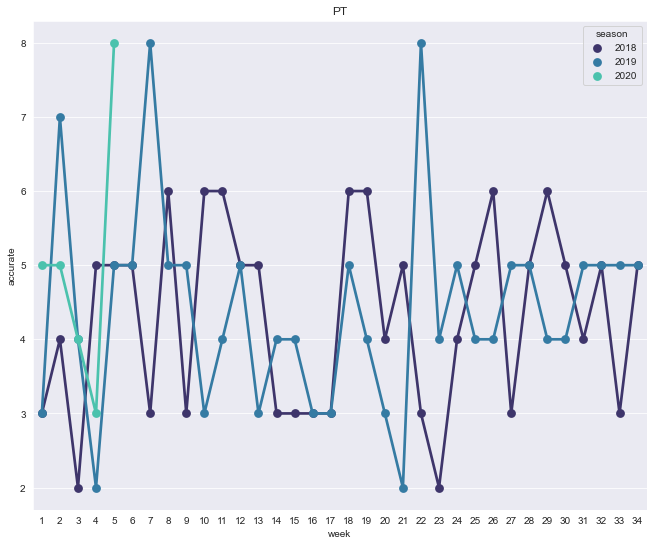

In [130]:
weeks_predictions(df)

Total wrong = 19/44
Error = 0.432


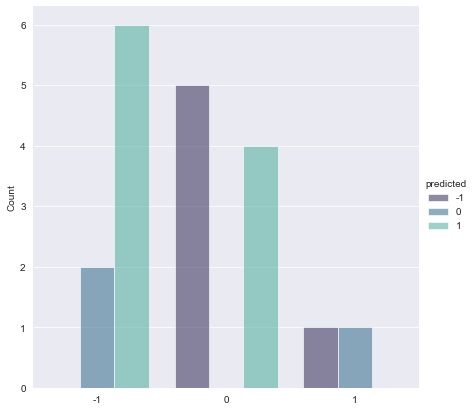

In [131]:
wrong_predictions(df, 2020)

In [23]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='0', clf_to_save='nb_ovo', if_anova='both', log_transform=True)
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
9


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
18


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
27


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
36


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
45


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
54


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
63


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
72


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
81


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
90


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
99


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
108


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
117


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
126


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
135


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
144


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
153


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
162


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
171


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
180


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
189


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
198


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
207


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
216


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
225


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
234


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
243


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
252


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
261


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
270


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
279


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
288


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
297


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
306


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
315


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
324


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
333


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
342


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
351


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
360


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
369


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
378


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
387


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
396


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
405


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
414


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
423


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
432


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
441


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
450


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
459


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
468


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
477


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
486


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
495


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
504


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
513


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
522


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
531


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
540


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
549


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
558


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
567


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
576


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
585


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
594


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
603


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
612


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/en

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
620


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thes

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
629


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
638


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
647


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
656


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


{'rforest': {'score': 0.4634146341463415, 'predicted': [[15, 97, 43], [31, 204, 48], [33, 100, 85]]}, 'nb_ovo': {'score': 0.49390243902439024, 'predicted': [[23, 80, 52], [35, 193, 55], [31, 79, 108]]}, 'svc_ovo': {'score': 0.4878048780487805, 'predicted': [[11, 91, 53], [18, 203, 62], [21, 91, 106]]}, 'ridge': {'score': 0.4603658536585366, 'predicted': [[46, 57, 52], [72, 154, 57], [50, 66, 102]]}}


Total accurate = 324/656
Accuracy = 0.494


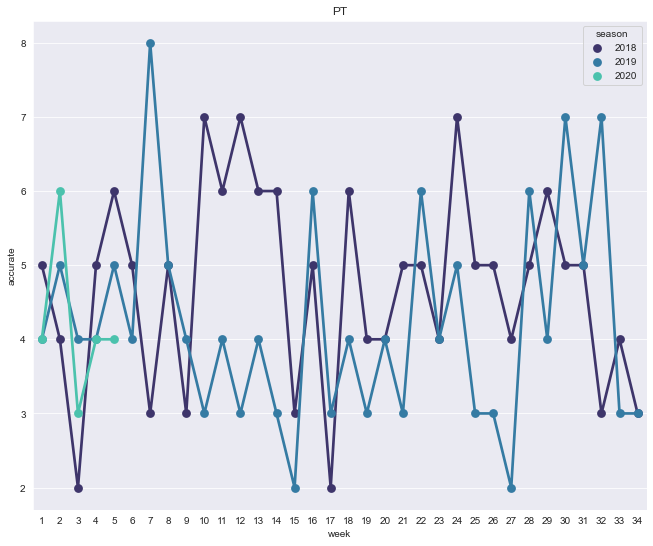

In [24]:
weeks_predictions(df)

Total wrong = 23/44
Error = 0.523


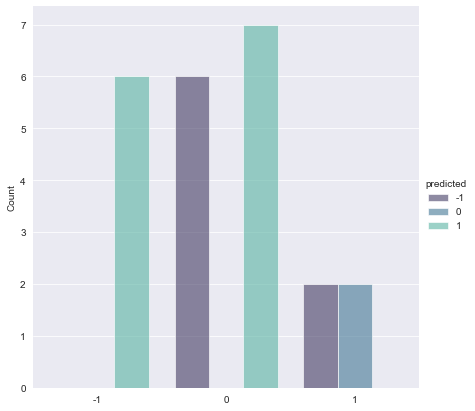

In [25]:
wrong_predictions(df, 2020)

In [26]:
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = custom_test(dct, '8', '3', statistics_to_test, up_to_season, year_window=year_window, week=week, extras='1', clf_to_save='svc_ovo', if_anova=False)
print(accuracy)

Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
9
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
18
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
27
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
36
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
45
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
54
Train Method
Plain train set: all games from past seasons
A

Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
477
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
486
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
495
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
504
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
513
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
522
Train Method
Plain train set: all games from past se

Total accurate = 303/656
Accuracy = 0.462


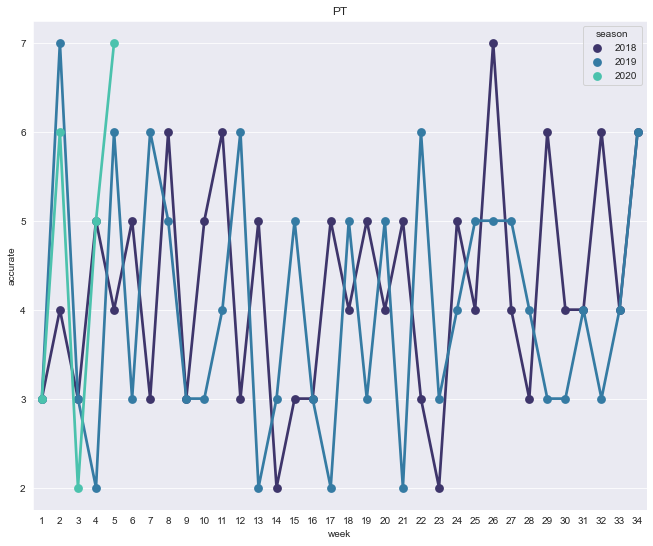

In [27]:
weeks_predictions(df)

Total wrong = 21/44
Error = 0.477


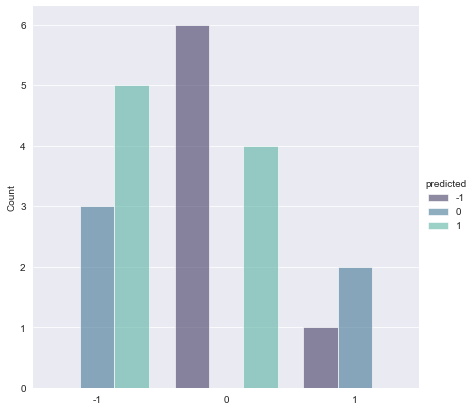

In [28]:
wrong_predictions(df, 2020)

In [132]:
"""
    Everything to retrieve the data
"""
global country
country = 'BE'
league = '144'
curr_week = 5
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

0-1
hola
0-4
hola
1-2
hola
2-4
hola
2-3
hola
1-3
hola
0-1
hola
1-3
hola
2-3
hola
1-2
hola
0-6
hola
0-3
hola
2-3
hola
0-2
hola
1-2
hola
0-6
0-2
1-3
1-3
0-1
1-3
1-3
2-3
1-2
0-3
2-4
0-1
0-1
1-2
0-1
1-2
4-1
hola
2-1
hola
3-1
hola
2-0
hola
2-1
hola
4-1
hola
5-2
hola
3-0
hola
2-1
hola
2-0
hola
3-1
hola
3-0
hola
4-1
hola
6-3
hola
5-1
hola
3-1
hola
0-6
0-2
1-3
1-3
0-1
1-3
1-3
2-3
1-2
0-3
2-4
0-1
0-1
1-2
0-1
1-2
0-1
hola
0-4
hola
1-2
hola
2-4
hola
2-3
hola
1-3
hola
0-1
hola
1-3
hola
2-3
hola
1-2
hola
0-6
hola
0-3
hola
2-3
hola
0-2
hola
1-2
hola
0-6
0-2
1-3
1-3
0-1
1-3
1-3
2-3
1-2
0-3
2-4
0-1
0-1
1-2
0-1
1-2
4-1
hola
2-1
hola
3-1
hola
2-0
hola
2-1
hola
4-1
hola
5-2
hola
3-0
hola
2-1
hola
2-0
hola
3-1
hola
3-0
hola
4-1
hola
6-3
hola
5-1
hola
3-1
hola
0-6
0-2
1-3
1-3
0-1
1-3
1-3
2-3
1-2
0-3
2-4
0-1
0-1
1-2
0-1
1-2
0-1
hola
0-4
hola
1-2
hola
2-4
hola
2-3
hola
1-3
hola
0-1
hola
1-3
hola
2-3
hola
1-2
hola
0-6
hola
0-3
hola
2-3
hola
0-2
hola
1-2
hola
4-1
hola
2-1
hola
3-1
hola
2-0
hola
2-1
hola
4-1
ho

In [140]:
statistics_to_test["week"] = pd.to_numeric(statistics_to_test["week"], errors = 'coerce')
statistics_to_test.dropna(inplace = True)

In [152]:
# Uses majority voting
up_to_season = 2020
year_window = 4 #2019 + 1
week = 6
accuracy, df = vote_test(dct, statistics_to_test, up_to_season, classifiers=["nb_ovo", "rforest"], year_window=year_window, week=week)
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
8


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
16


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
24


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
32


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
40


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
48


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
56


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
64


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
72


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
80


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
88


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
96


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
104


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
112


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
120


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
128


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
136


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
144


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
152


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
160


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
168


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
176


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
184


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
192


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
200


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
208


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
216


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
224


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
232


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
240


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
248


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
256


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
264


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
272


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
280


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
288


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
296


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
304


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
312


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
320


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
328


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
336


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
344


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
352


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
360


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
368


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
376


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
384


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
392


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
400


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
408


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
416


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
424


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
432


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
440


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
448


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
456


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
464


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
473


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
482


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
491


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
500


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Test Method
Current season only median
Applies pezzali to test set
509


/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/envs/thesis/lib/python3.7/site-packages/

{'rforest_p': {'score': 0.3418467583497053, 'predicted': [[8, 66, 44], [18, 126, 90], [17, 100, 40]]}, 'nb_ovo': {'score': 0.4263261296660118, 'predicted': [[16, 70, 32], [32, 165, 37], [19, 102, 36]]}, 'svc_ovo_p': {'score': 0.3516699410609037, 'predicted': [[12, 66, 40], [28, 126, 80], [21, 95, 41]]}, 'rforest': {'score': 0.43418467583497056, 'predicted': [[3, 70, 45], [11, 174, 49], [7, 106, 44]]}, 'vote': {'score': 0.4263261296660118, 'predicted': [[15, 65, 38], [34, 165, 35], [20, 100, 37]]}}


Total accurate = 217/509
Accuracy = 0.426


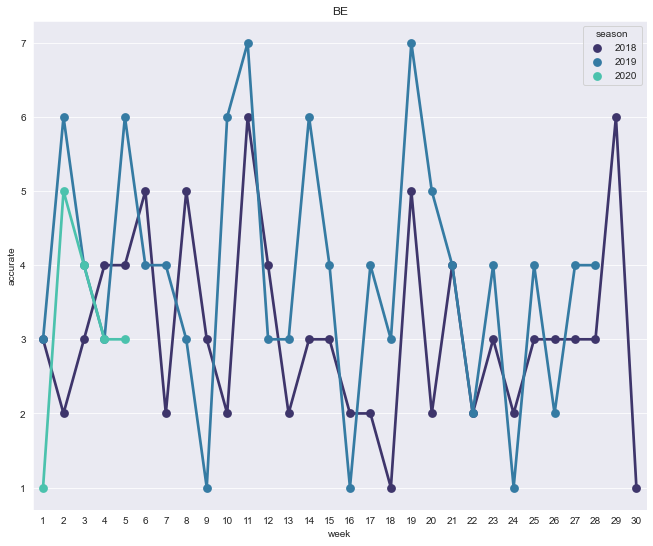

In [153]:
weeks_predictions(df)

Total wrong = 29/45
Error = 0.644


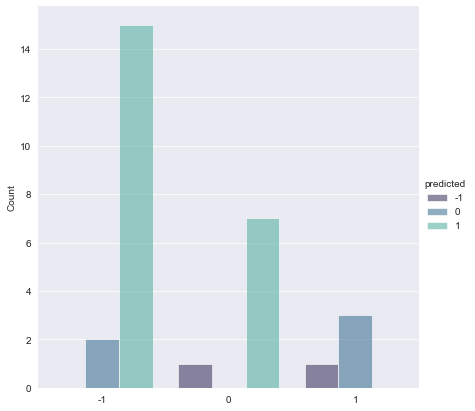

In [154]:
wrong_predictions(df, 2020)

In [ ]:
# When playing home or away
teams_predictions(df, 2020, "both")

In [ ]:
# When playing home
teams_predictions(df, 2020, "home_team.id")

In [ ]:
# When playing away
teams_predictions(df, 2020, "away_team.id")

In [ ]:
# Chi-squared test for clusters
chi_df,_,_,_,_,_,_ = get_data(dct, statistics_to_test)
chi_squared_clusters(chi_df, target)